In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import matplotlib.cm as cm
# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
# Configuration
FILE_PATH = 'C:/Users/zachh/Desktop/CAS593_git/data/AD_strengths/AD_Strengths_FY1987-2024_normalized.xlsx'
YEARS = range(1987, 2025)
BRANCHES = ['Army', 'Navy', 'Marine Corps', 'Air Force', 'Space Force']
print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
def load_all_years(file_path):
    """Load all year sheets and consolidate into a single DataFrame"""
    xl_file = pd.ExcelFile(file_path)
    all_data = []
    
    for year in YEARS:
        sheet_name = str(year)
        if sheet_name in xl_file.sheet_names:
            df = pd.read_excel(file_path, sheet_name=sheet_name)
            df['Year'] = year
            all_data.append(df)
    
    # Concatenate all years
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Clean up - remove rows where Rank/Grade is NaN
    combined_df = combined_df.dropna(subset=['Rank/Grade'])
    
    # Remove summary rows
    summary_rows = ['TOTAL OFFICER', 'TOTAL ENLISTED', 'GRAND TOTAL', 'CADETS - MIDSHIPMEN']
    combined_df = combined_df[~combined_df['Rank/Grade'].isin(summary_rows)]
    
    return combined_df

# Load the data
df_all = load_all_years(FILE_PATH)

print(f"Data loaded: {len(df_all)} total rows")
print(f"Years covered: {df_all['Year'].min()} to {df_all['Year'].max()}")
print(f"Unique ranks: {df_all['Rank/Grade'].nunique()}")
print("\nFirst few rows:")
print(df_all.head())


Data loaded: 912 total rows
Years covered: 1987 to 2024
Unique ranks: 24

First few rows:
                        Rank/Grade  Total DoD    Army    Navy  Marine Corps  \
0                GENERAL - ADMIRAL       36.0    11.0     9.0           3.0   
1        LT GENERAL - VICE ADMIRAL      124.0    46.0    33.0           7.0   
2   MAJ GENERAL - REAR ADMIRAL (U)      364.0   142.0    84.0          23.0   
3  BRIG GENERAL - REAR ADMIRAL (L)      531.0   199.0   129.0          37.0   
4                COLONEL - CAPTAIN    14604.0  4587.0  3766.0         634.0   

   Air Force  Space Force  Year  
0       13.0          0.0  1987  
1       38.0          0.0  1987  
2      115.0          0.0  1987  
3      166.0          0.0  1987  
4     5617.0          0.0  1987  


In [4]:
# Define rank categories for analysis
OFFICER_RANKS = [
    'GENERAL - ADMIRAL',
    'LT GENERAL - VICE ADMIRAL',
    'MAJ GENERAL - REAR ADMIRAL (U)',
    'BRIG GENERAL - REAR ADMIRAL (L)',
    'COLONEL - CAPTAIN',
    'LIEUTENANT COL - COMMANDER',
    'MAJOR - LT COMMANDER',
    'CAPTAIN - LIEUTENANT',
    '1ST LIEUTENANT - LIEUTENANT (JG)',
    '2ND LIEUTENANT - ENSIGN'
]

WARRANT_OFFICER_RANKS = [
    'CHIEF WARRANT OFFICER W-5',
    'CHIEF WARRANT OFFICER W-4',
    'CHIEF WARRANT OFFICER W-3',
    'CHIEF WARRANT OFFICER W-2',
    'WARRANT OFFICER W-1'
]

ENLISTED_RANKS = ['E-9', 'E-8', 'E-7', 'E-6', 'E-5', 'E-4', 'E-3', 'E-2', 'E-1']

# Senior leadership cohort: E-9s, Colonels, and Generals
SENIOR_COHORT = [
    'E-9',
    'COLONEL - CAPTAIN',
    'BRIG GENERAL - REAR ADMIRAL (L)',
    'MAJ GENERAL - REAR ADMIRAL (U)',
    'LT GENERAL - VICE ADMIRAL',
    'GENERAL - ADMIRAL'
]

def create_rank_order():
    """Create a dictionary for proper rank ordering"""
    all_ranks = OFFICER_RANKS + WARRANT_OFFICER_RANKS + ENLISTED_RANKS
    return {rank: i for i, rank in enumerate(all_ranks)}

RANK_ORDER = create_rank_order()

def sort_by_rank(df):
    """Sort DataFrame by rank hierarchy"""
    df = df.copy()
    df['rank_order'] = df['Rank/Grade'].map(RANK_ORDER)
    df = df.sort_values(['Year', 'rank_order'])
    df = df.drop('rank_order', axis=1)
    return df

print("Rank categories defined!")
print(f"Officer ranks: {len(OFFICER_RANKS)}")
print(f"Warrant officer ranks: {len(WARRANT_OFFICER_RANKS)}")
print(f"Enlisted ranks: {len(ENLISTED_RANKS)}")
print(f"Senior cohort: {len(SENIOR_COHORT)}")

Rank categories defined!
Officer ranks: 10
Warrant officer ranks: 5
Enlisted ranks: 9
Senior cohort: 6


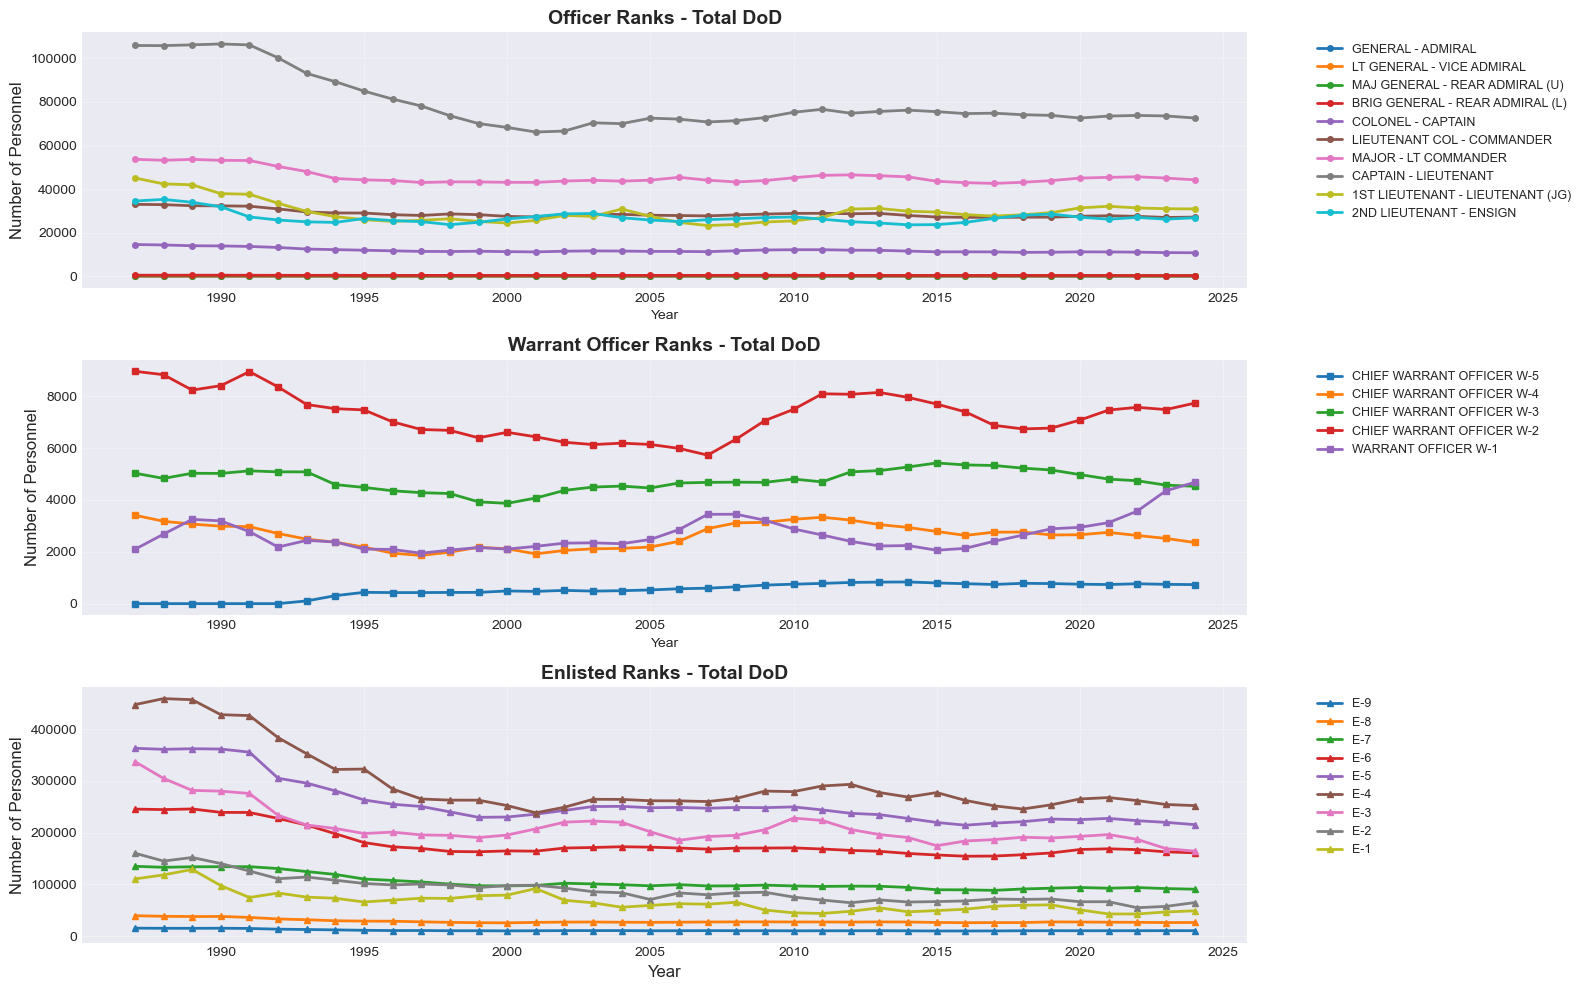

Plot 1 generated: Numerical size of each rank over time


In [5]:
def plot_rank_sizes_over_time(df, column='Total DoD', figsize=(16, 10)):
    """Plot absolute numbers for each rank over time"""
    
    # Pivot data for easier plotting
    pivot_df = df.pivot(index='Year', columns='Rank/Grade', values=column)
    
    # Sort columns by rank hierarchy
    rank_cols = [r for r in OFFICER_RANKS + WARRANT_OFFICER_RANKS + ENLISTED_RANKS 
                 if r in pivot_df.columns]
    pivot_df = pivot_df[rank_cols]
    
    # Create subplots for better visibility
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    
    # Officers
    officer_cols = [r for r in OFFICER_RANKS if r in pivot_df.columns]
    pivot_df[officer_cols].plot(ax=axes[0], linewidth=2, marker='o', markersize=4)
    axes[0].set_title(f'Officer Ranks - {column}', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Number of Personnel', fontsize=12)
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    axes[0].grid(True, alpha=0.3)
    
    # Warrant Officers
    warrant_cols = [r for r in WARRANT_OFFICER_RANKS if r in pivot_df.columns]
    if warrant_cols:
        pivot_df[warrant_cols].plot(ax=axes[1], linewidth=2, marker='s', markersize=4)
        axes[1].set_title(f'Warrant Officer Ranks - {column}', fontsize=14, fontweight='bold')
        axes[1].set_ylabel('Number of Personnel', fontsize=12)
        axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        axes[1].grid(True, alpha=0.3)
    
    # Enlisted
    enlisted_cols = [r for r in ENLISTED_RANKS if r in pivot_df.columns]
    pivot_df[enlisted_cols].plot(ax=axes[2], linewidth=2, marker='^', markersize=4)
    axes[2].set_title(f'Enlisted Ranks - {column}', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Number of Personnel', fontsize=12)
    axes[2].set_xlabel('Year', fontsize=12)
    axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Generate the plot
fig1 = plot_rank_sizes_over_time(df_all, column='Total DoD')
plt.show()

print("Plot 1 generated: Numerical size of each rank over time")


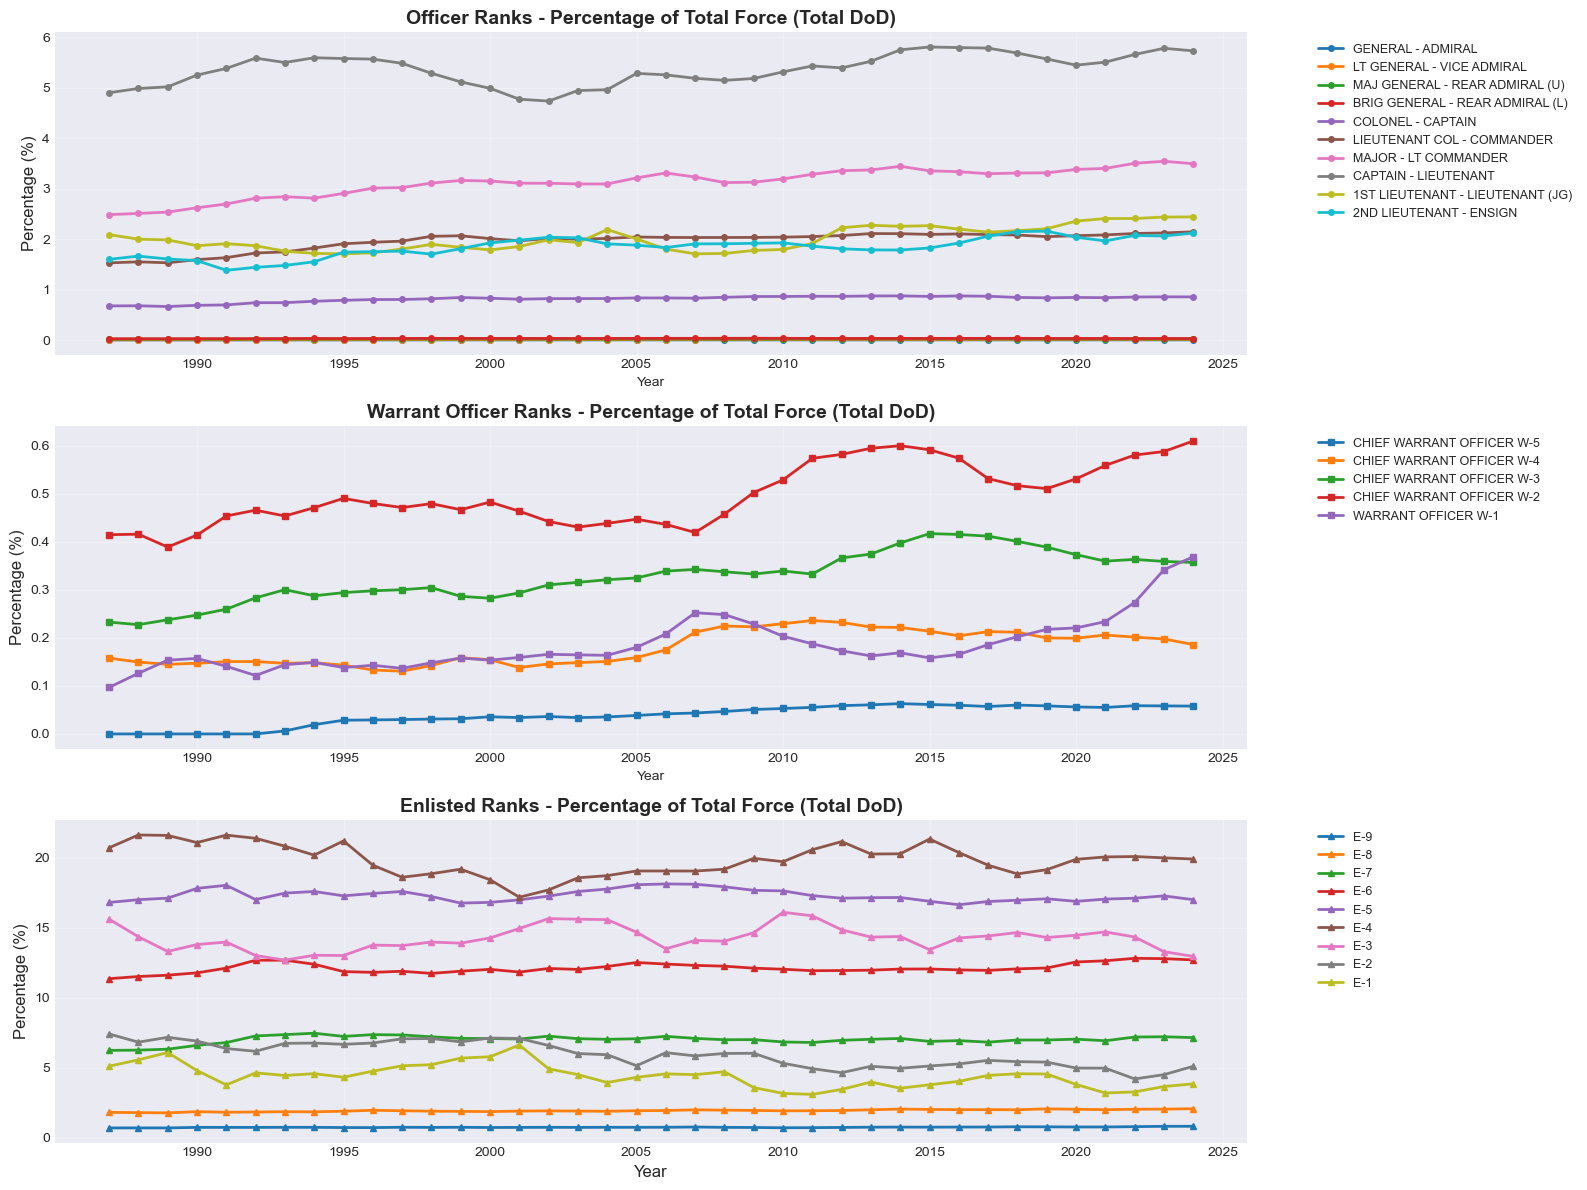

Plot 2 generated: Relative size (percentages) of each rank over time


In [6]:
def calculate_percentages(df, column='Total DoD'):
    """Calculate percentage of each rank relative to total"""
    df_pct = df.copy()
    
    # Calculate total for each year
    yearly_totals = df.groupby('Year')[column].sum().reset_index()
    yearly_totals.columns = ['Year', 'YearTotal']
    
    # Merge and calculate percentages
    df_pct = df_pct.merge(yearly_totals, on='Year')
    df_pct[f'{column}_pct'] = (df_pct[column] / df_pct['YearTotal']) * 100
    
    return df_pct

def plot_rank_percentages(df, column='Total DoD', figsize=(16, 12)):
    """Plot percentage of total for each rank over time"""
    
    # Calculate percentages
    df_pct = calculate_percentages(df, column)
    
    # Pivot data
    pivot_df = df_pct.pivot(index='Year', columns='Rank/Grade', values=f'{column}_pct')
    
    # Sort columns by rank hierarchy
    rank_cols = [r for r in OFFICER_RANKS + WARRANT_OFFICER_RANKS + ENLISTED_RANKS 
                 if r in pivot_df.columns]
    pivot_df = pivot_df[rank_cols]
    
    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    
    # Officers
    officer_cols = [r for r in OFFICER_RANKS if r in pivot_df.columns]
    pivot_df[officer_cols].plot(ax=axes[0], linewidth=2, marker='o', markersize=4)
    axes[0].set_title(f'Officer Ranks - Percentage of Total Force ({column})', 
                      fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Percentage (%)', fontsize=12)
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    axes[0].grid(True, alpha=0.3)
    
    # Warrant Officers
    warrant_cols = [r for r in WARRANT_OFFICER_RANKS if r in pivot_df.columns]
    if warrant_cols:
        pivot_df[warrant_cols].plot(ax=axes[1], linewidth=2, marker='s', markersize=4)
        axes[1].set_title(f'Warrant Officer Ranks - Percentage of Total Force ({column})', 
                          fontsize=14, fontweight='bold')
        axes[1].set_ylabel('Percentage (%)', fontsize=12)
        axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        axes[1].grid(True, alpha=0.3)
    
    # Enlisted
    enlisted_cols = [r for r in ENLISTED_RANKS if r in pivot_df.columns]
    pivot_df[enlisted_cols].plot(ax=axes[2], linewidth=2, marker='^', markersize=4)
    axes[2].set_title(f'Enlisted Ranks - Percentage of Total Force ({column})', 
                      fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Percentage (%)', fontsize=12)
    axes[2].set_xlabel('Year', fontsize=12)
    axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Generate the plot
fig2 = plot_rank_percentages(df_all, column='Total DoD')
plt.show()

print("Plot 2 generated: Relative size (percentages) of each rank over time")

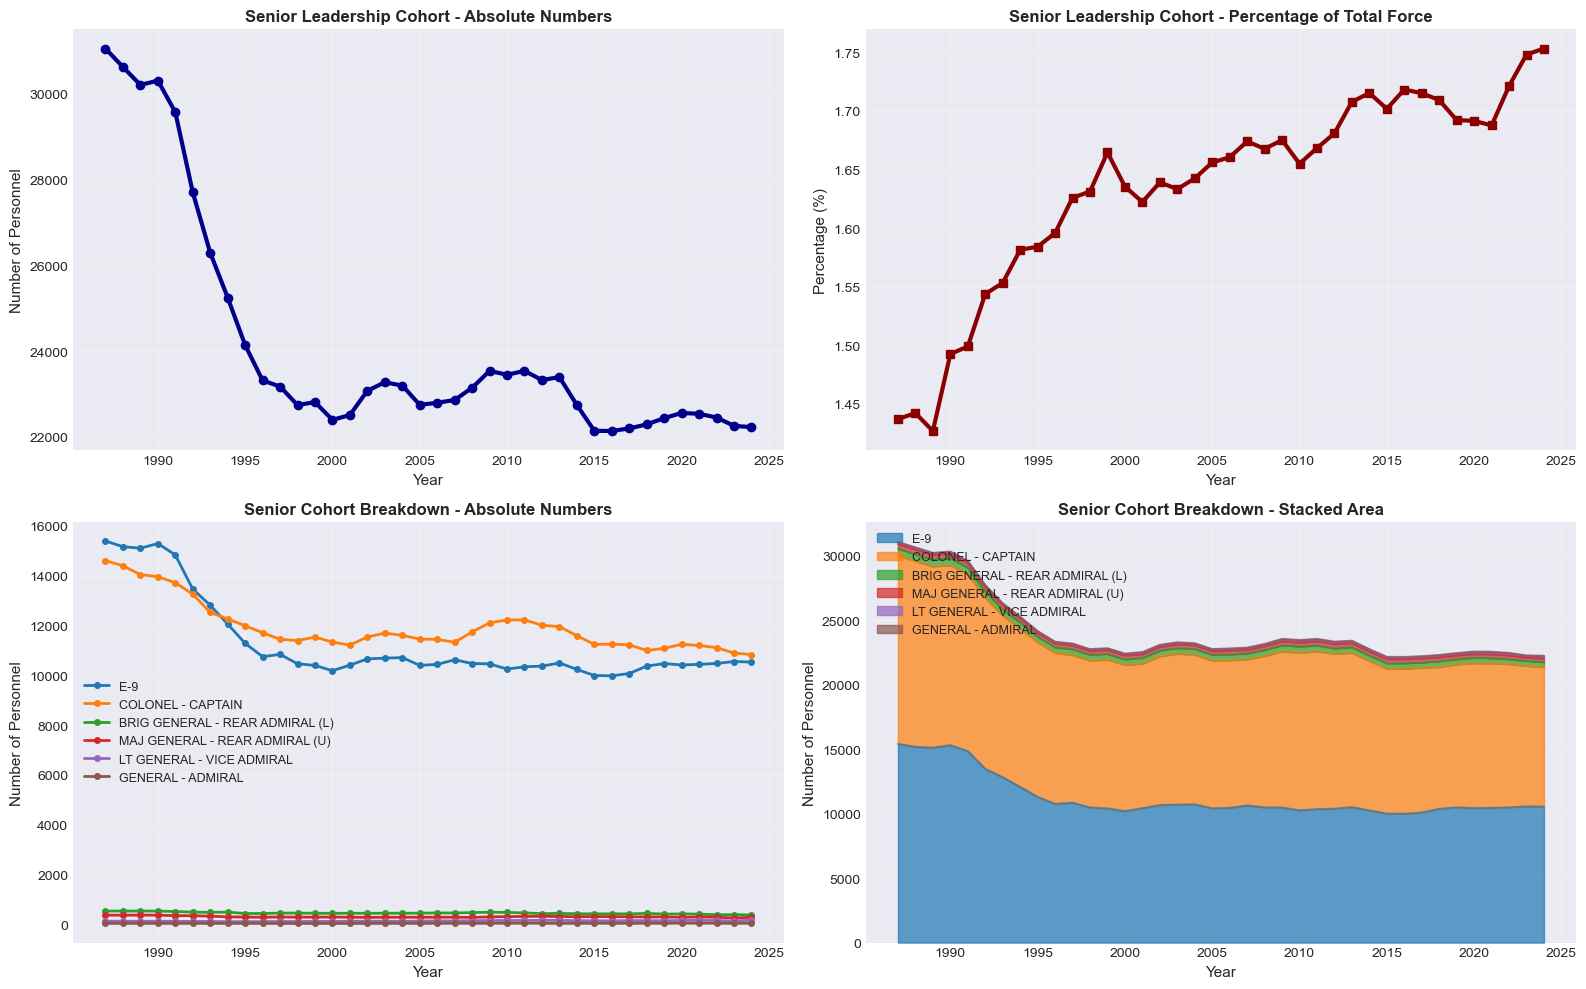


Senior Leadership Cohort Summary Statistics:
              Year  SeniorCohort  OverallTotal  SeniorCohort_pct
count    38.000000     38.000000  3.800000e+01         38.000000
mean   2005.500000  24114.184211  1.486972e+06          1.635507
std      11.113055   2703.748518  2.581075e+05          0.085260
min    1987.000000  22135.000000  1.267738e+06          1.426916
25%    1996.250000  22515.000000  1.333949e+06          1.602467
50%    2005.500000  23108.000000  1.387564e+06          1.658266
75%    2014.750000  23537.000000  1.451978e+06          1.691999
max    2024.000000  31052.000000  2.160727e+06          1.753201

Senior Cohort includes: E-9, COLONEL - CAPTAIN, BRIG GENERAL - REAR ADMIRAL (L), MAJ GENERAL - REAR ADMIRAL (U), LT GENERAL - VICE ADMIRAL, GENERAL - ADMIRAL


In [7]:
def analyze_senior_cohort(df, column='Total DoD'):
    """Analyze the senior leadership cohort over time"""
    
    # Filter for senior cohort ranks
    df_senior = df[df['Rank/Grade'].isin(SENIOR_COHORT)].copy()
    
    # Calculate total senior cohort by year
    senior_totals = df_senior.groupby('Year')[column].sum().reset_index()
    senior_totals.columns = ['Year', 'SeniorCohort']
    
    # Calculate overall total by year
    overall_totals = df.groupby('Year')[column].sum().reset_index()
    overall_totals.columns = ['Year', 'OverallTotal']
    
    # Merge and calculate percentages
    cohort_analysis = senior_totals.merge(overall_totals, on='Year')
    cohort_analysis['SeniorCohort_pct'] = (
        cohort_analysis['SeniorCohort'] / cohort_analysis['OverallTotal'] * 100
    )
    
    return cohort_analysis, df_senior

def plot_senior_cohort(df, column='Total DoD', figsize=(16, 10)):
    """Plot senior leadership cohort analysis"""
    
    cohort_summary, df_senior = analyze_senior_cohort(df, column)
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Plot 1: Absolute numbers of senior cohort
    axes[0, 0].plot(cohort_summary['Year'], cohort_summary['SeniorCohort'], 
                    linewidth=3, marker='o', markersize=6, color='darkblue')
    axes[0, 0].set_title('Senior Leadership Cohort - Absolute Numbers', 
                         fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Number of Personnel', fontsize=11)
    axes[0, 0].set_xlabel('Year', fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Percentage of total force
    axes[0, 1].plot(cohort_summary['Year'], cohort_summary['SeniorCohort_pct'], 
                    linewidth=3, marker='s', markersize=6, color='darkred')
    axes[0, 1].set_title('Senior Leadership Cohort - Percentage of Total Force', 
                         fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Percentage (%)', fontsize=11)
    axes[0, 1].set_xlabel('Year', fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Breakdown by rank within cohort (absolute)
    pivot_abs = df_senior.pivot(index='Year', columns='Rank/Grade', values=column)
    rank_order_cohort = [r for r in SENIOR_COHORT if r in pivot_abs.columns]
    pivot_abs[rank_order_cohort].plot(ax=axes[1, 0], linewidth=2, marker='o', markersize=4)
    axes[1, 0].set_title('Senior Cohort Breakdown - Absolute Numbers', 
                         fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Number of Personnel', fontsize=11)
    axes[1, 0].set_xlabel('Year', fontsize=11)
    axes[1, 0].legend(fontsize=9)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Stacked area chart showing composition
    pivot_abs[rank_order_cohort].plot.area(ax=axes[1, 1], alpha=0.7)
    axes[1, 1].set_title('Senior Cohort Breakdown - Stacked Area', 
                         fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Number of Personnel', fontsize=11)
    axes[1, 1].set_xlabel('Year', fontsize=11)
    axes[1, 1].legend(fontsize=9, loc='upper left')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, cohort_summary

# Generate the plots
fig3, cohort_data = plot_senior_cohort(df_all, column='Total DoD')
plt.show()

# Display summary statistics
print("\nSenior Leadership Cohort Summary Statistics:")
print(cohort_data.describe())
print(f"\nSenior Cohort includes: {', '.join(SENIOR_COHORT)}")

In [8]:
def prepare_branch_data(df, branch):
    """Prepare data for a specific branch"""
    df_branch = df[['Year', 'Rank/Grade', branch]].copy()
    df_branch = df_branch.rename(columns={branch: 'Personnel'})
    return df_branch

# Prepare data for each branch
branch_data = {}
for branch in BRANCHES:
    branch_data[branch] = prepare_branch_data(df_all, branch)
    print(f"{branch}: {branch_data[branch]['Personnel'].sum():,.0f} total personnel across all years")


Army: 20,308,473 total personnel across all years
Navy: 14,856,419 total personnel across all years
Marine Corps: 7,017,248 total personnel across all years
Air Force: 14,324,488 total personnel across all years
Space Force: 18,325 total personnel across all years



Generating rank size plot for Army...


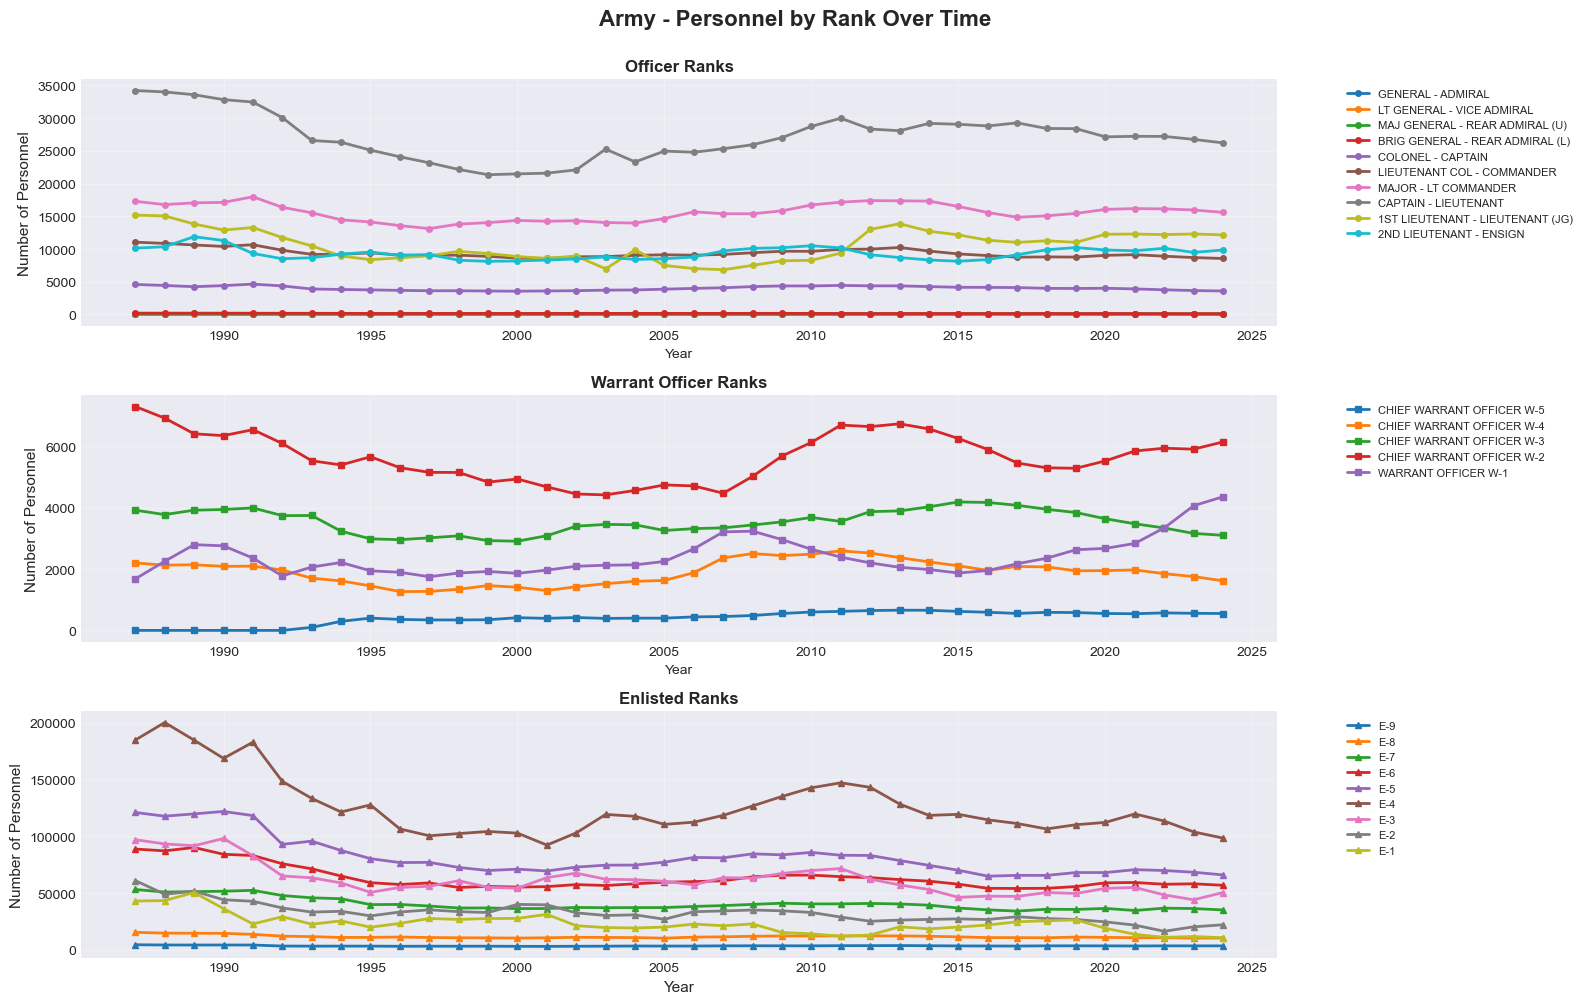


Generating rank size plot for Navy...


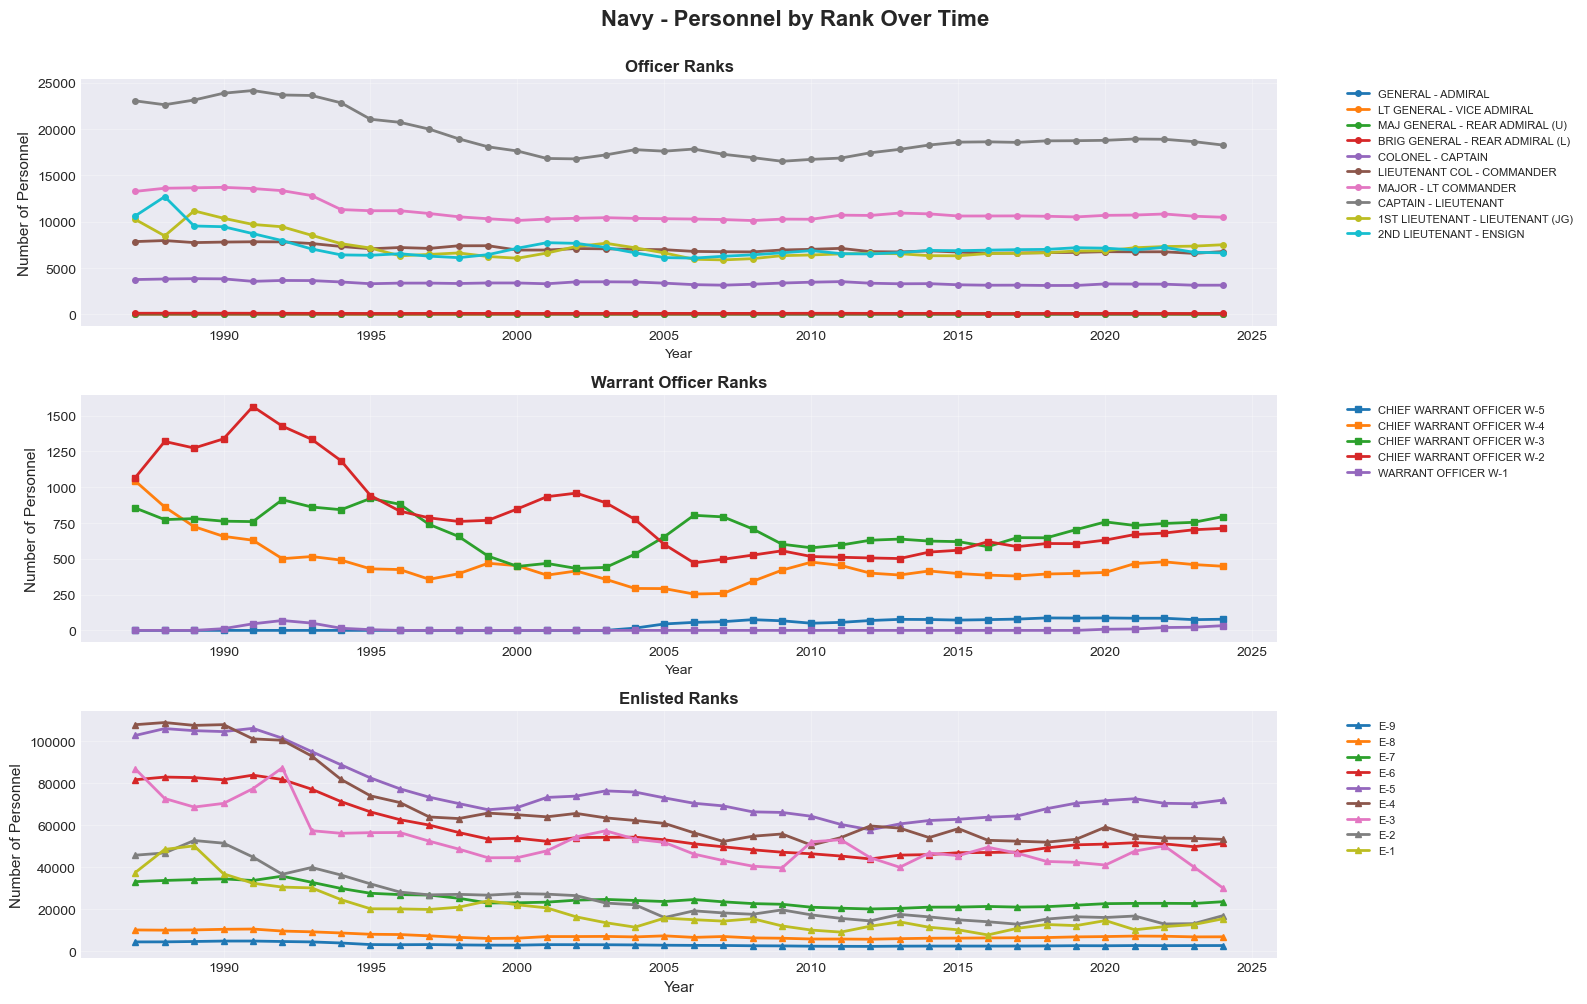


Generating rank size plot for Marine Corps...


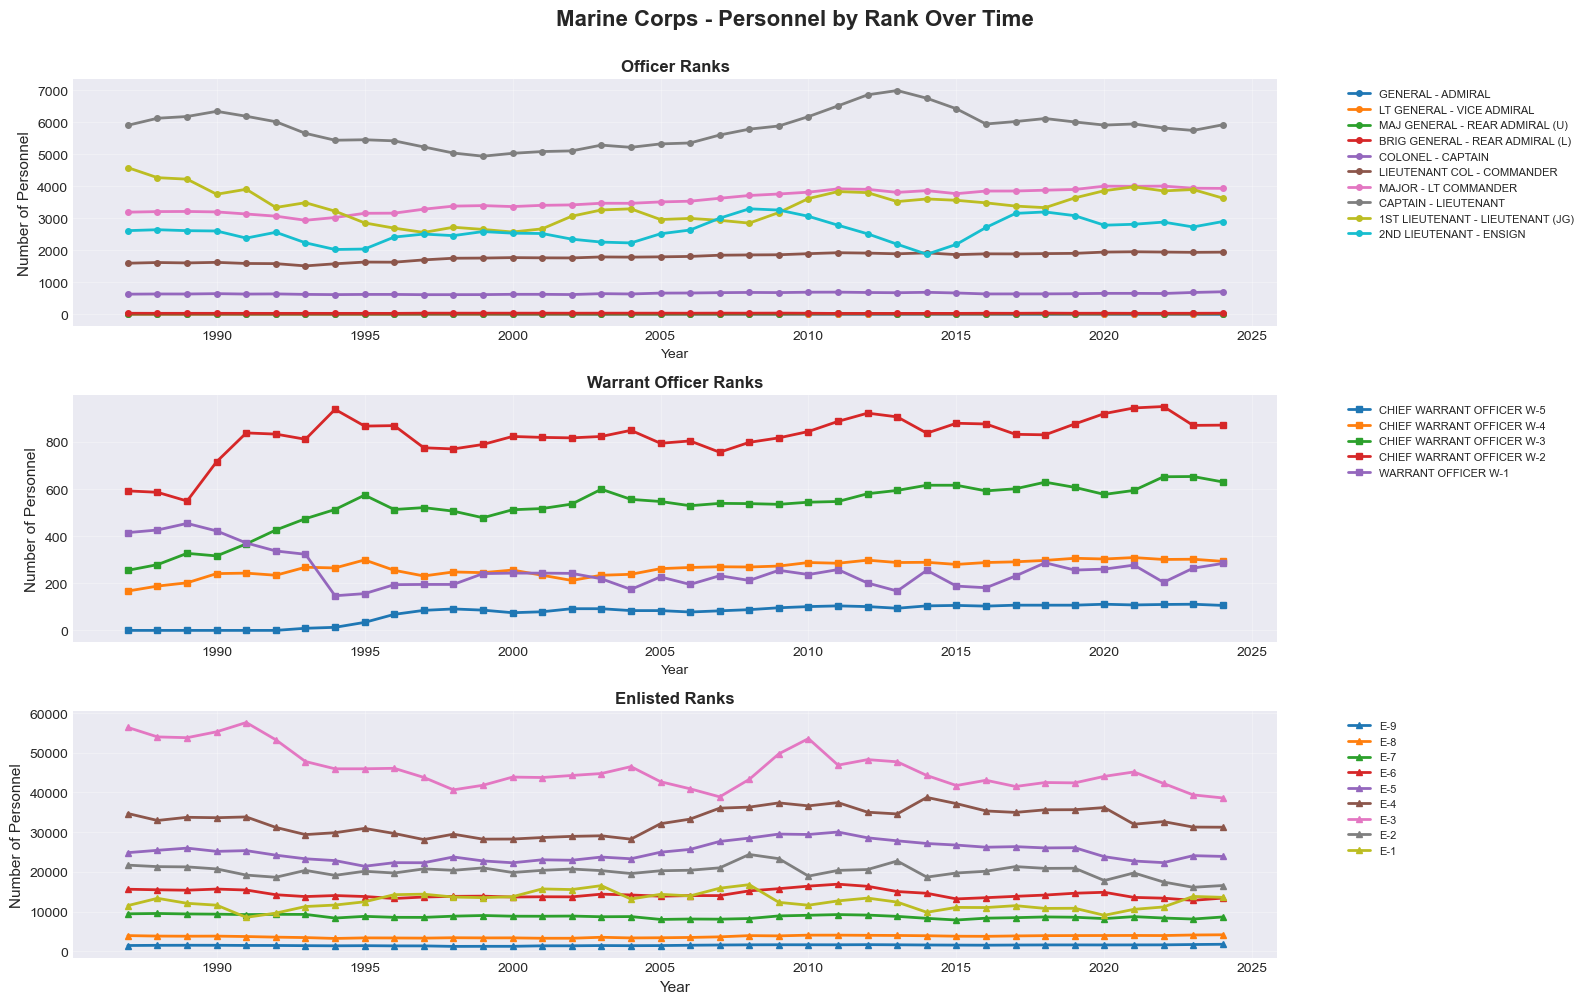


Generating rank size plot for Air Force...


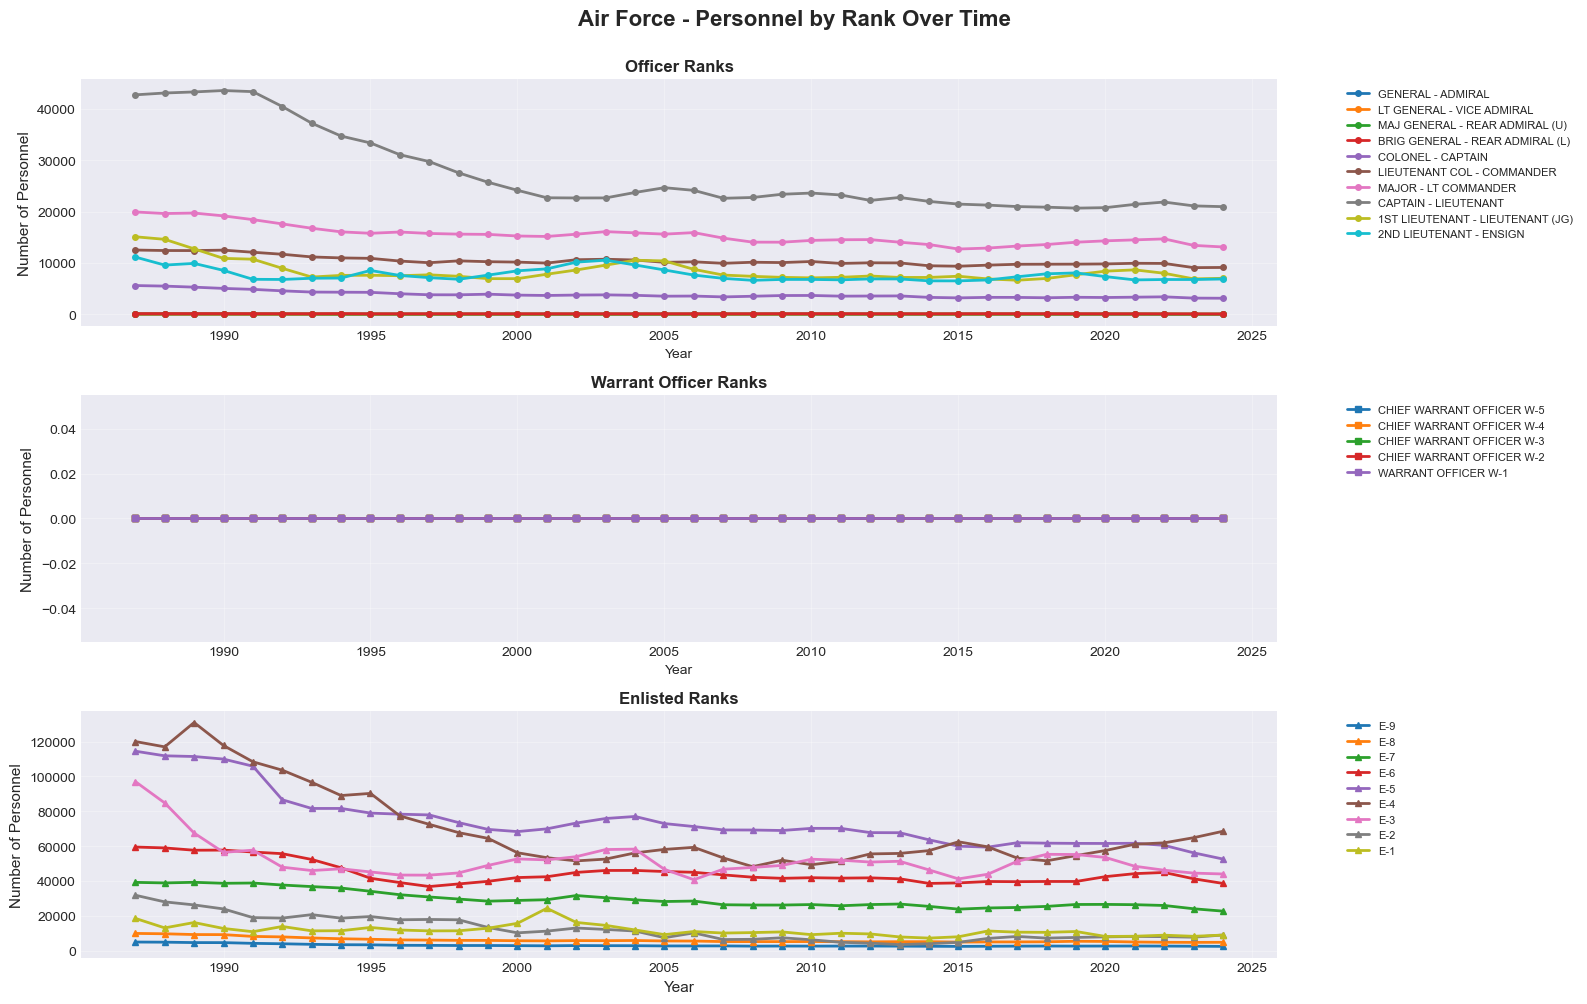


Generating rank size plot for Space Force...


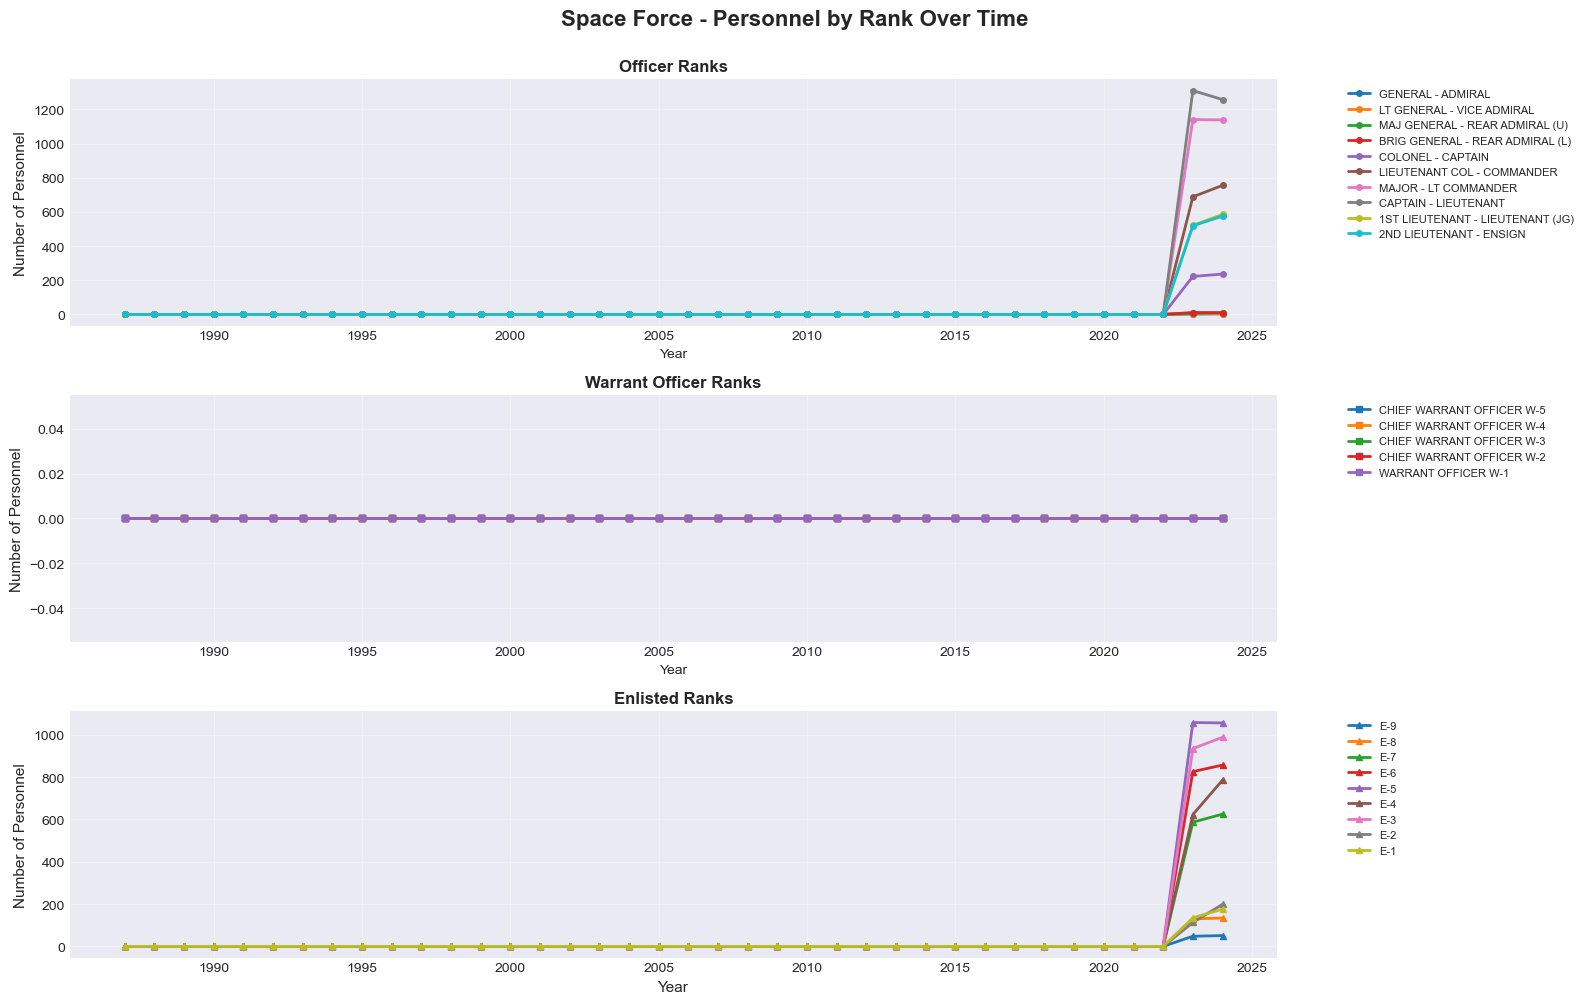

In [9]:
def plot_branch_rank_sizes(df, branch, figsize=(16, 10)):
    """Plot rank sizes for a specific branch"""
    
    df_branch = prepare_branch_data(df, branch)
    
    # Pivot data
    pivot_df = df_branch.pivot(index='Year', columns='Rank/Grade', values='Personnel')
    
    # Sort columns by rank hierarchy
    rank_cols = [r for r in OFFICER_RANKS + WARRANT_OFFICER_RANKS + ENLISTED_RANKS 
                 if r in pivot_df.columns]
    pivot_df = pivot_df[rank_cols]
    
    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    fig.suptitle(f'{branch} - Personnel by Rank Over Time', 
                 fontsize=16, fontweight='bold', y=1.00)
    
    # Officers
    officer_cols = [r for r in OFFICER_RANKS if r in pivot_df.columns]
    if officer_cols:
        pivot_df[officer_cols].plot(ax=axes[0], linewidth=2, marker='o', markersize=4)
        axes[0].set_title('Officer Ranks', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Number of Personnel', fontsize=11)
        axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        axes[0].grid(True, alpha=0.3)
    
    # Warrant Officers
    warrant_cols = [r for r in WARRANT_OFFICER_RANKS if r in pivot_df.columns]
    if warrant_cols:
        pivot_df[warrant_cols].plot(ax=axes[1], linewidth=2, marker='s', markersize=4)
        axes[1].set_title('Warrant Officer Ranks', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Number of Personnel', fontsize=11)
        axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        axes[1].grid(True, alpha=0.3)
    
    # Enlisted
    enlisted_cols = [r for r in ENLISTED_RANKS if r in pivot_df.columns]
    if enlisted_cols:
        pivot_df[enlisted_cols].plot(ax=axes[2], linewidth=2, marker='^', markersize=4)
        axes[2].set_title('Enlisted Ranks', fontsize=12, fontweight='bold')
        axes[2].set_ylabel('Number of Personnel', fontsize=11)
        axes[2].set_xlabel('Year', fontsize=11)
        axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Generate plots for each branch
for branch in BRANCHES:
    if branch_data[branch]['Personnel'].sum() > 0:  # Only plot if branch has data
        print(f"\nGenerating rank size plot for {branch}...")
        fig = plot_branch_rank_sizes(df_all, branch)
        plt.show()


Generating percentage plot for Army...


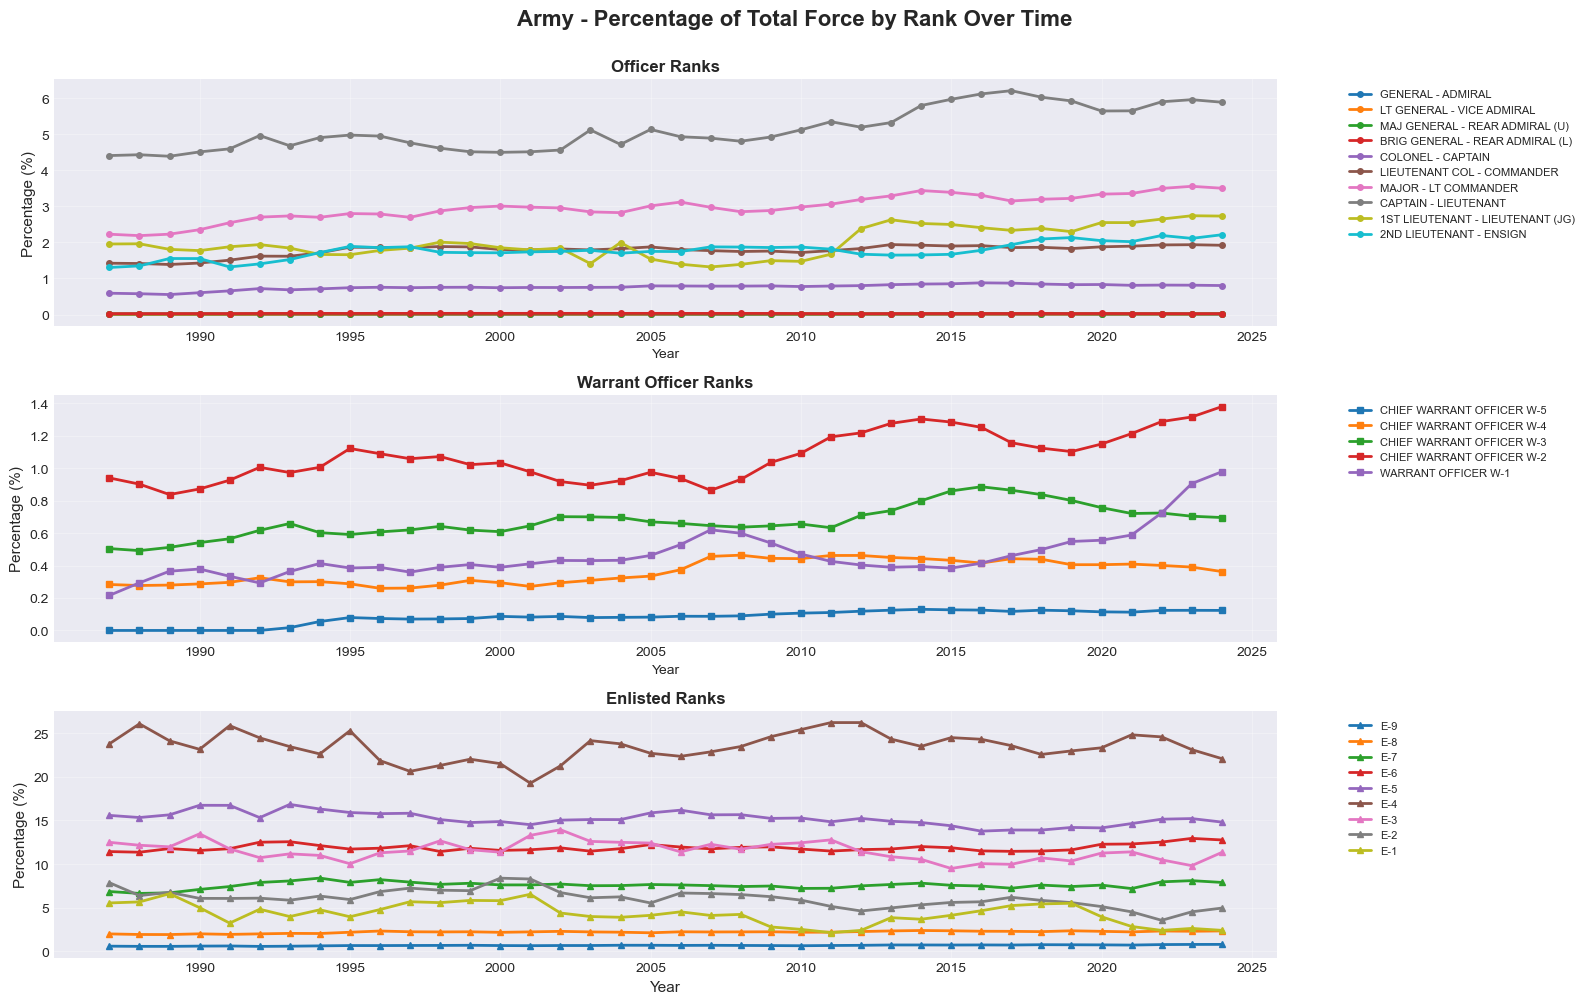


Generating percentage plot for Navy...


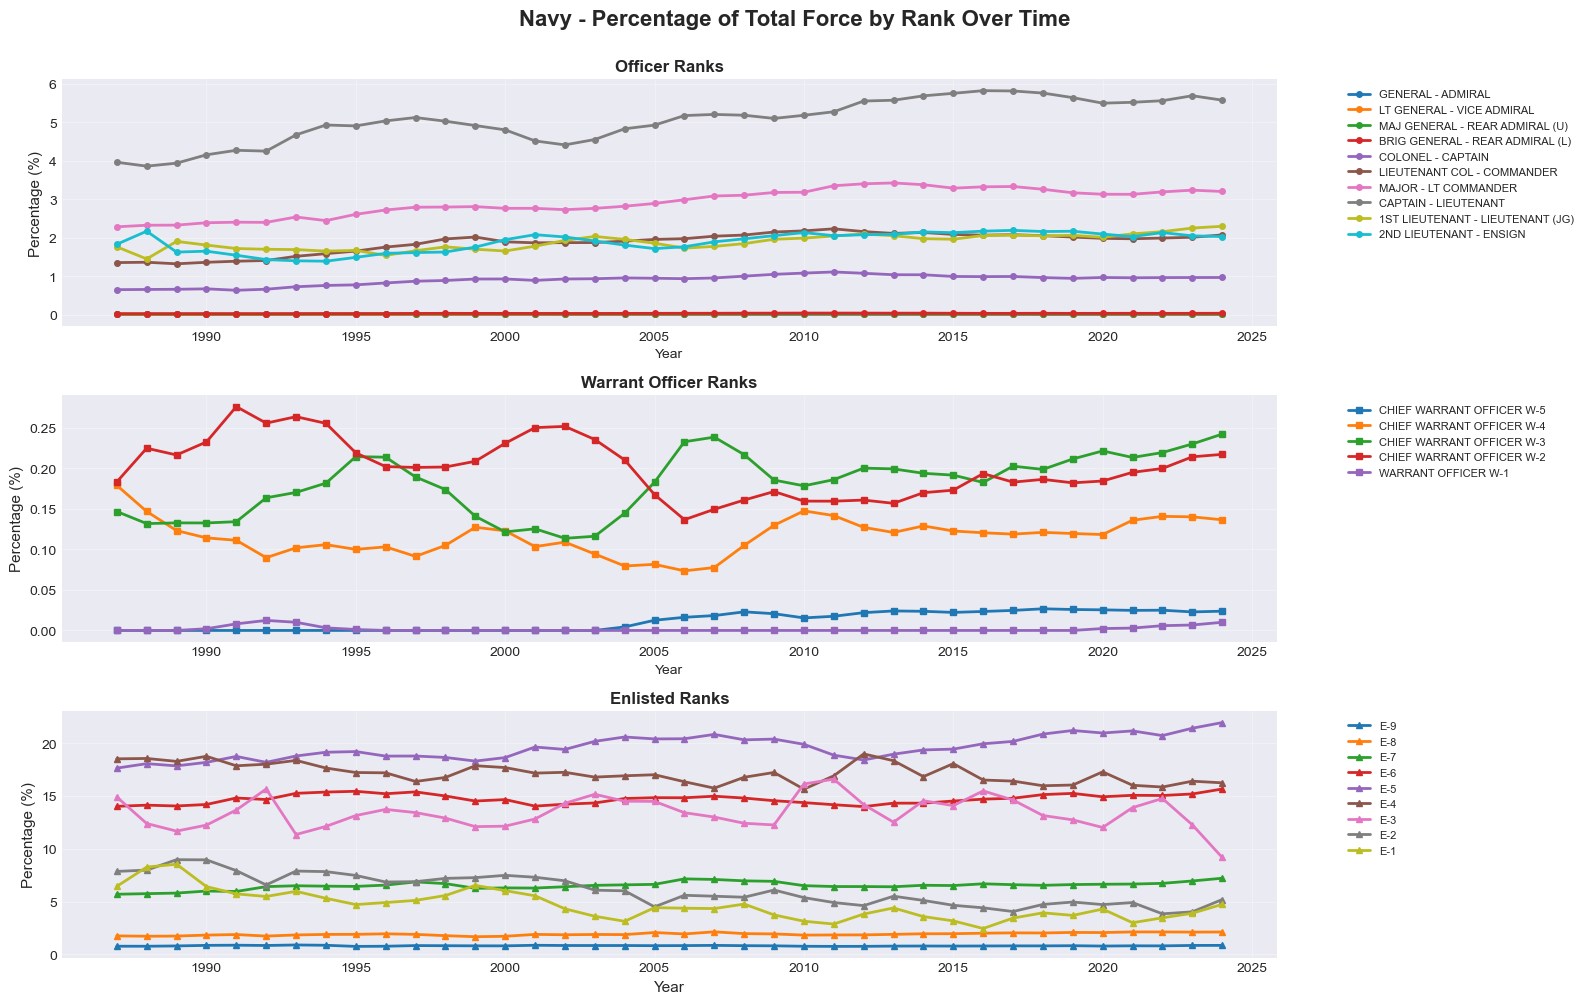


Generating percentage plot for Marine Corps...


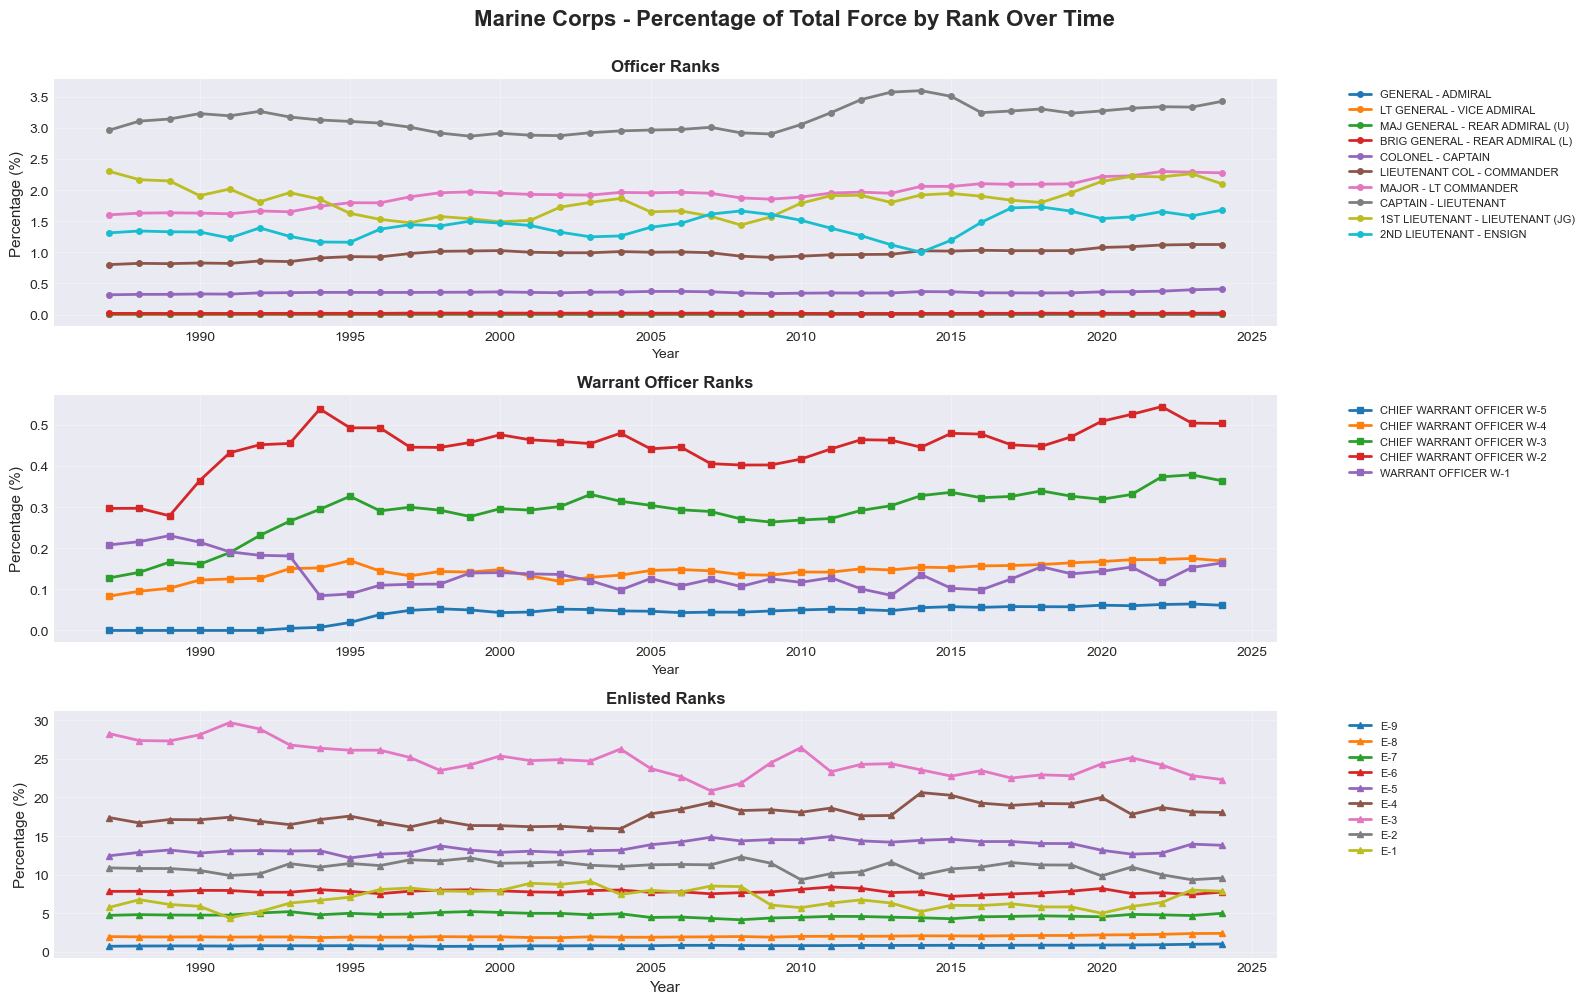


Generating percentage plot for Air Force...


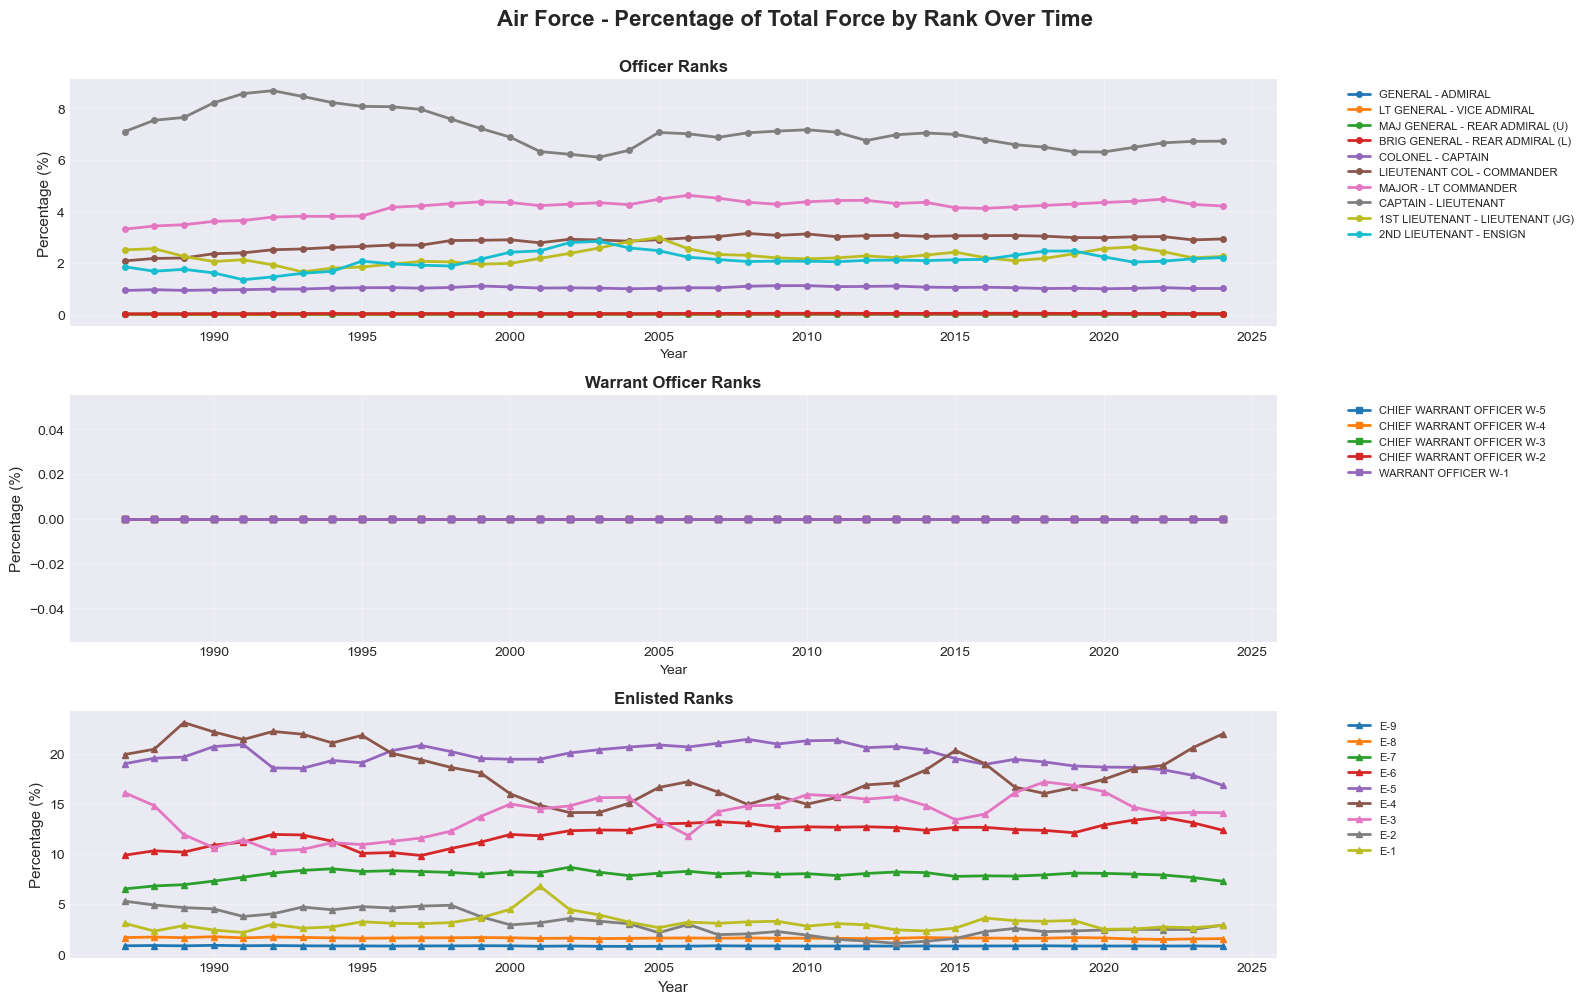


Generating percentage plot for Space Force...


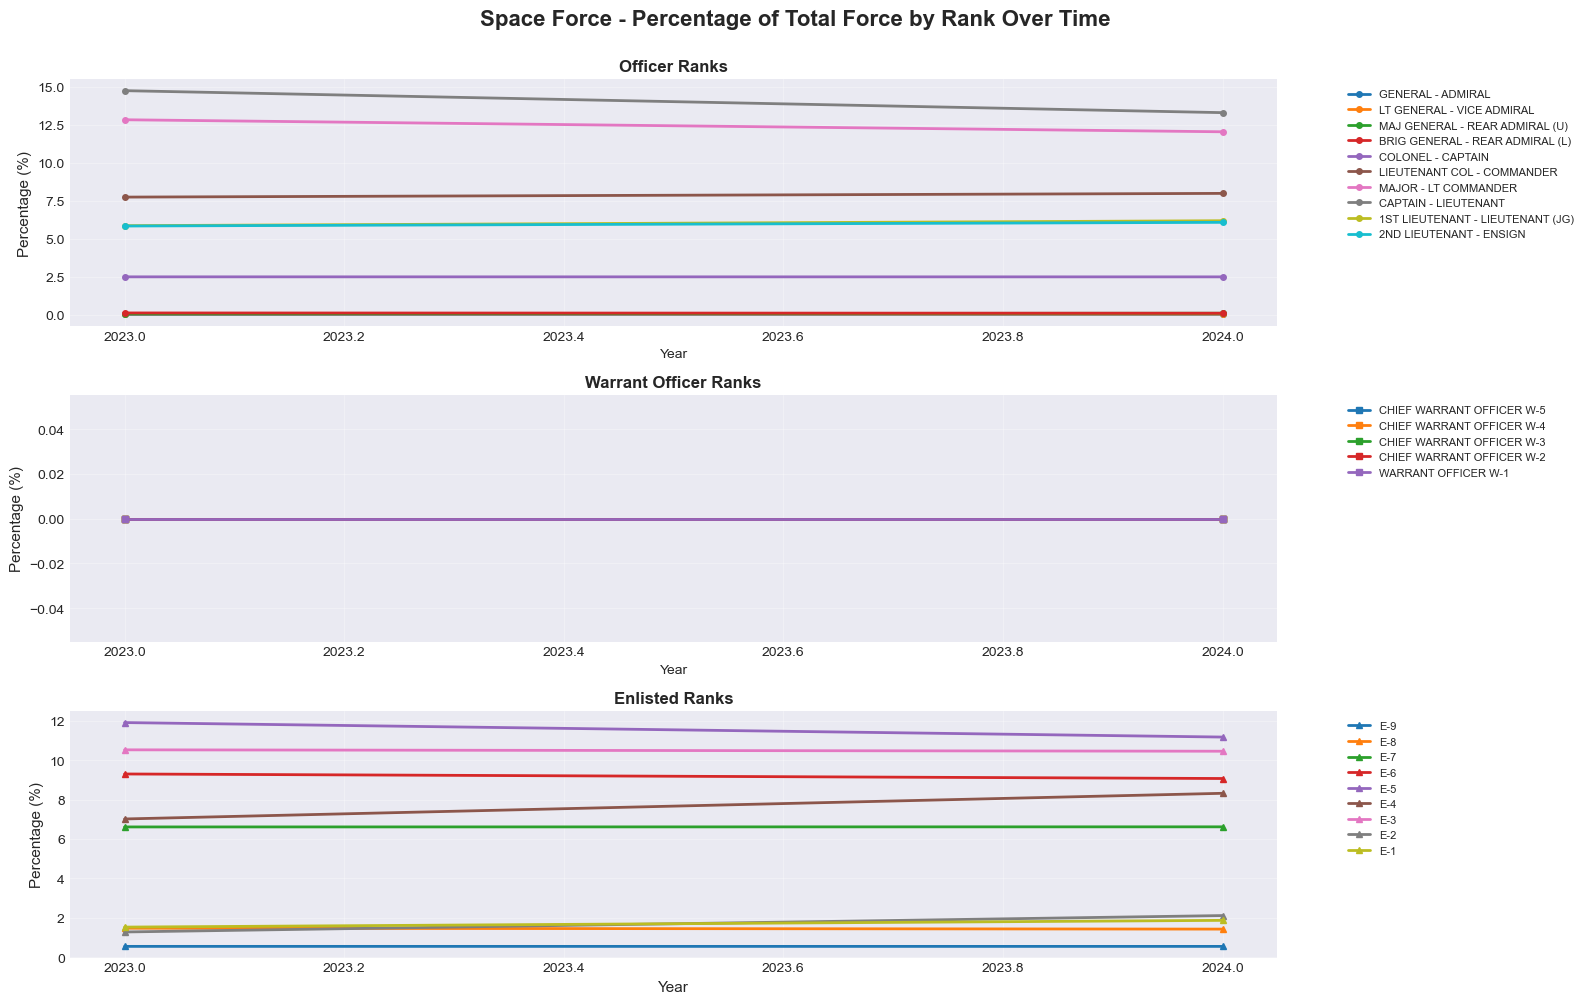

In [10]:
def plot_branch_rank_percentages(df, branch, figsize=(16, 10)):
    """Plot rank percentages for a specific branch"""
    
    df_branch = prepare_branch_data(df, branch)
    
    # Calculate percentages
    df_pct = calculate_percentages(df_branch, 'Personnel')
    
    # Pivot data
    pivot_df = df_pct.pivot(index='Year', columns='Rank/Grade', values='Personnel_pct')
    
    # Sort columns by rank hierarchy
    rank_cols = [r for r in OFFICER_RANKS + WARRANT_OFFICER_RANKS + ENLISTED_RANKS 
                 if r in pivot_df.columns]
    pivot_df = pivot_df[rank_cols]
    
    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    fig.suptitle(f'{branch} - Percentage of Total Force by Rank Over Time', 
                 fontsize=16, fontweight='bold', y=1.00)
    
    # Officers
    officer_cols = [r for r in OFFICER_RANKS if r in pivot_df.columns]
    if officer_cols:
        pivot_df[officer_cols].plot(ax=axes[0], linewidth=2, marker='o', markersize=4)
        axes[0].set_title('Officer Ranks', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Percentage (%)', fontsize=11)
        axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        axes[0].grid(True, alpha=0.3)
    
    # Warrant Officers
    warrant_cols = [r for r in WARRANT_OFFICER_RANKS if r in pivot_df.columns]
    if warrant_cols:
        pivot_df[warrant_cols].plot(ax=axes[1], linewidth=2, marker='s', markersize=4)
        axes[1].set_title('Warrant Officer Ranks', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Percentage (%)', fontsize=11)
        axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        axes[1].grid(True, alpha=0.3)
    
    # Enlisted
    enlisted_cols = [r for r in ENLISTED_RANKS if r in pivot_df.columns]
    if enlisted_cols:
        pivot_df[enlisted_cols].plot(ax=axes[2], linewidth=2, marker='^', markersize=4)
        axes[2].set_title('Enlisted Ranks', fontsize=12, fontweight='bold')
        axes[2].set_ylabel('Percentage (%)', fontsize=11)
        axes[2].set_xlabel('Year', fontsize=11)
        axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Generate plots for each branch
for branch in BRANCHES:
    if branch_data[branch]['Personnel'].sum() > 0:  # Only plot if branch has data
        print(f"\nGenerating percentage plot for {branch}...")
        fig = plot_branch_rank_percentages(df_all, branch)
        plt.show()




Generating senior cohort analysis for Army...


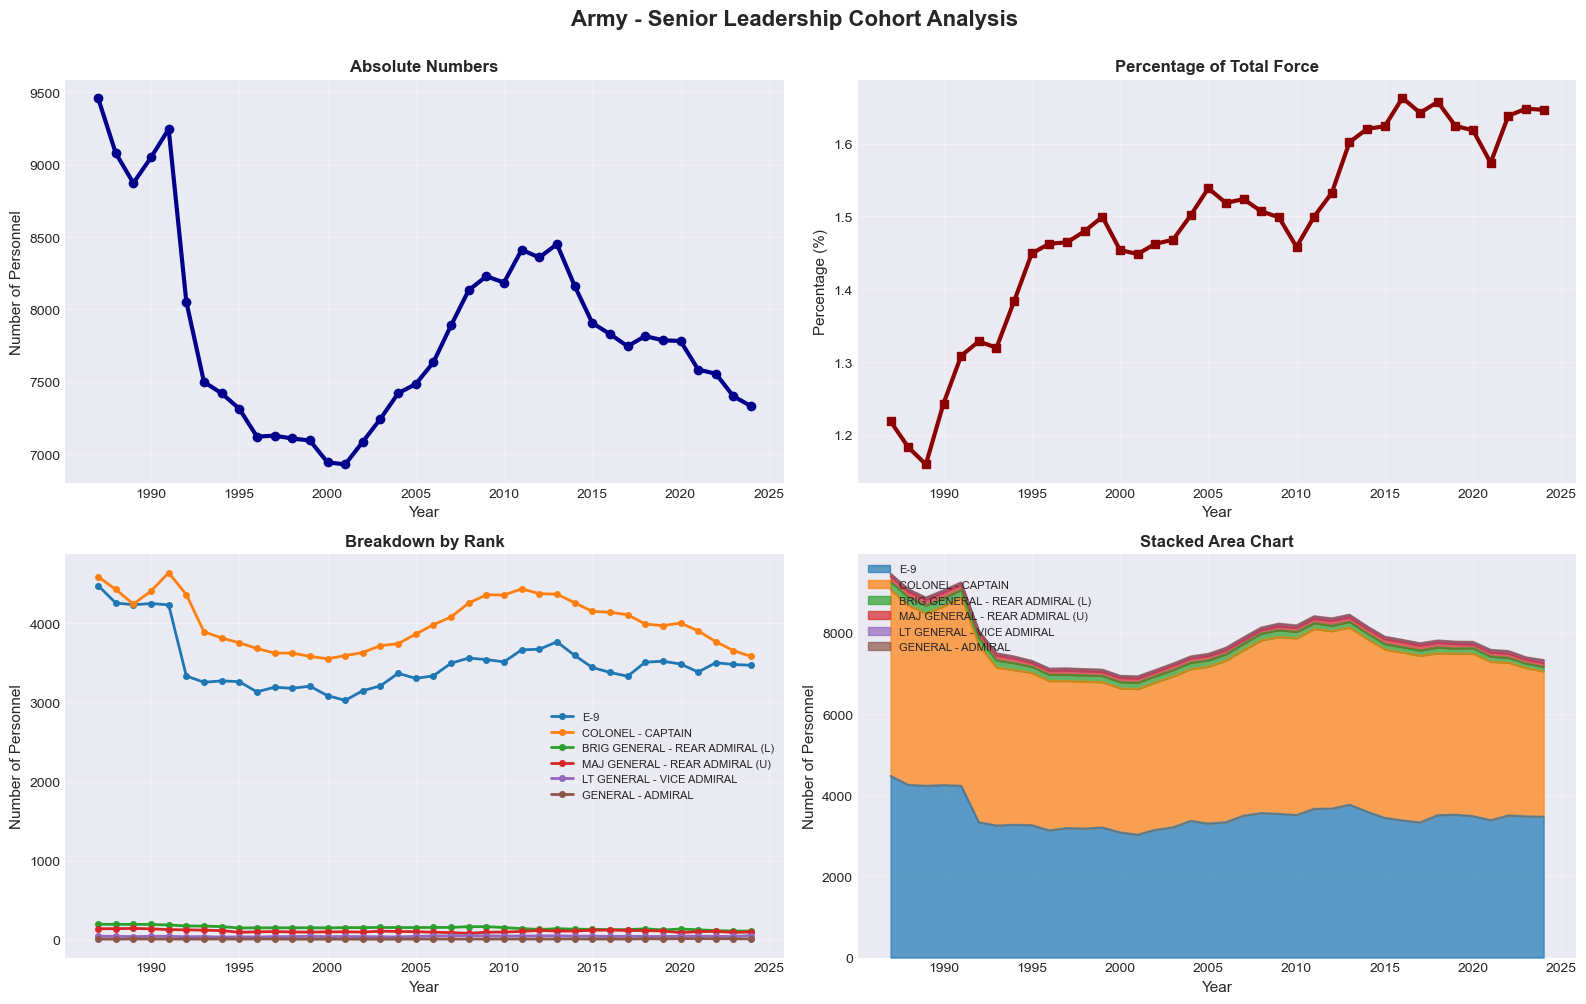


Generating senior cohort analysis for Navy...


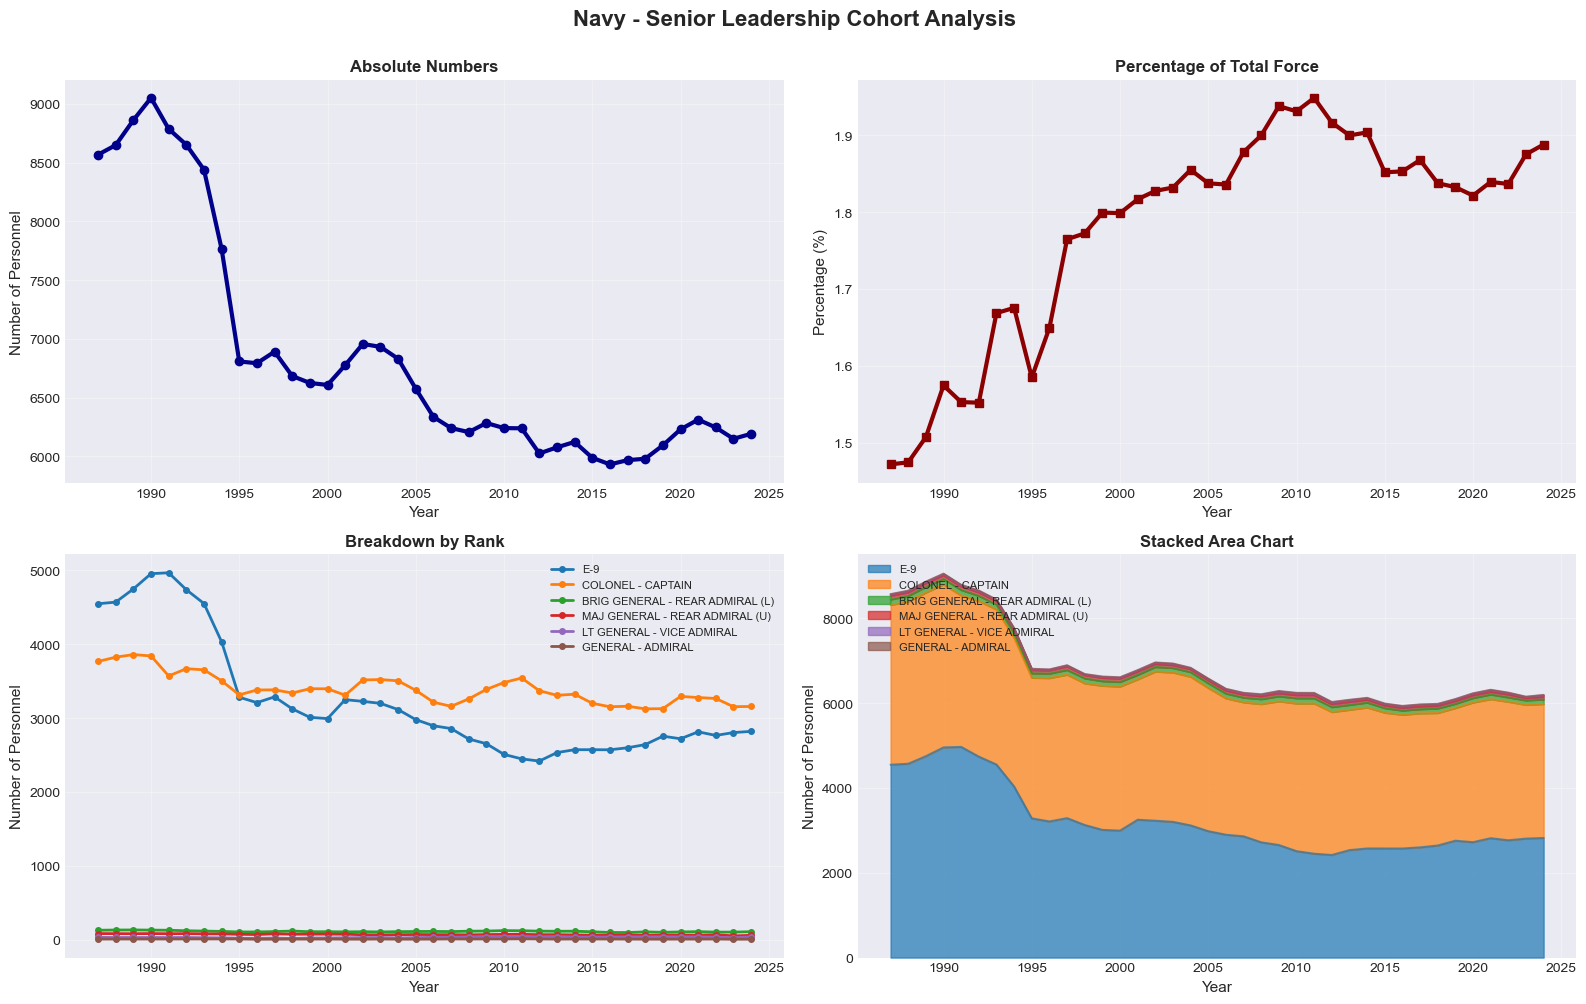


Generating senior cohort analysis for Marine Corps...


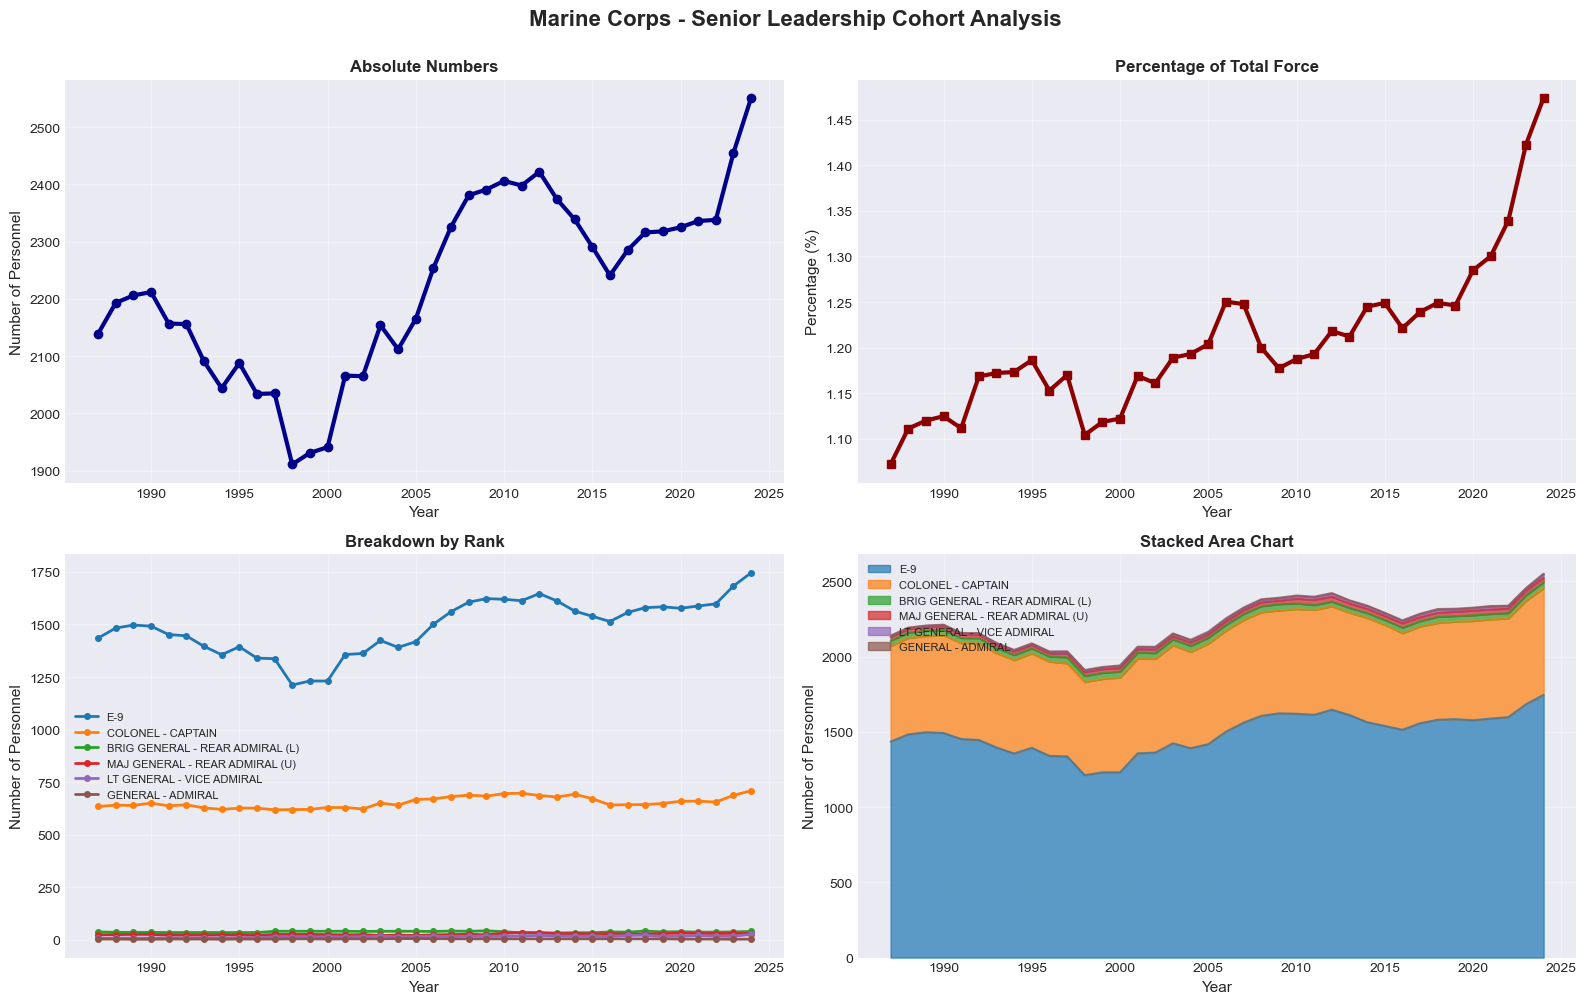


Generating senior cohort analysis for Air Force...


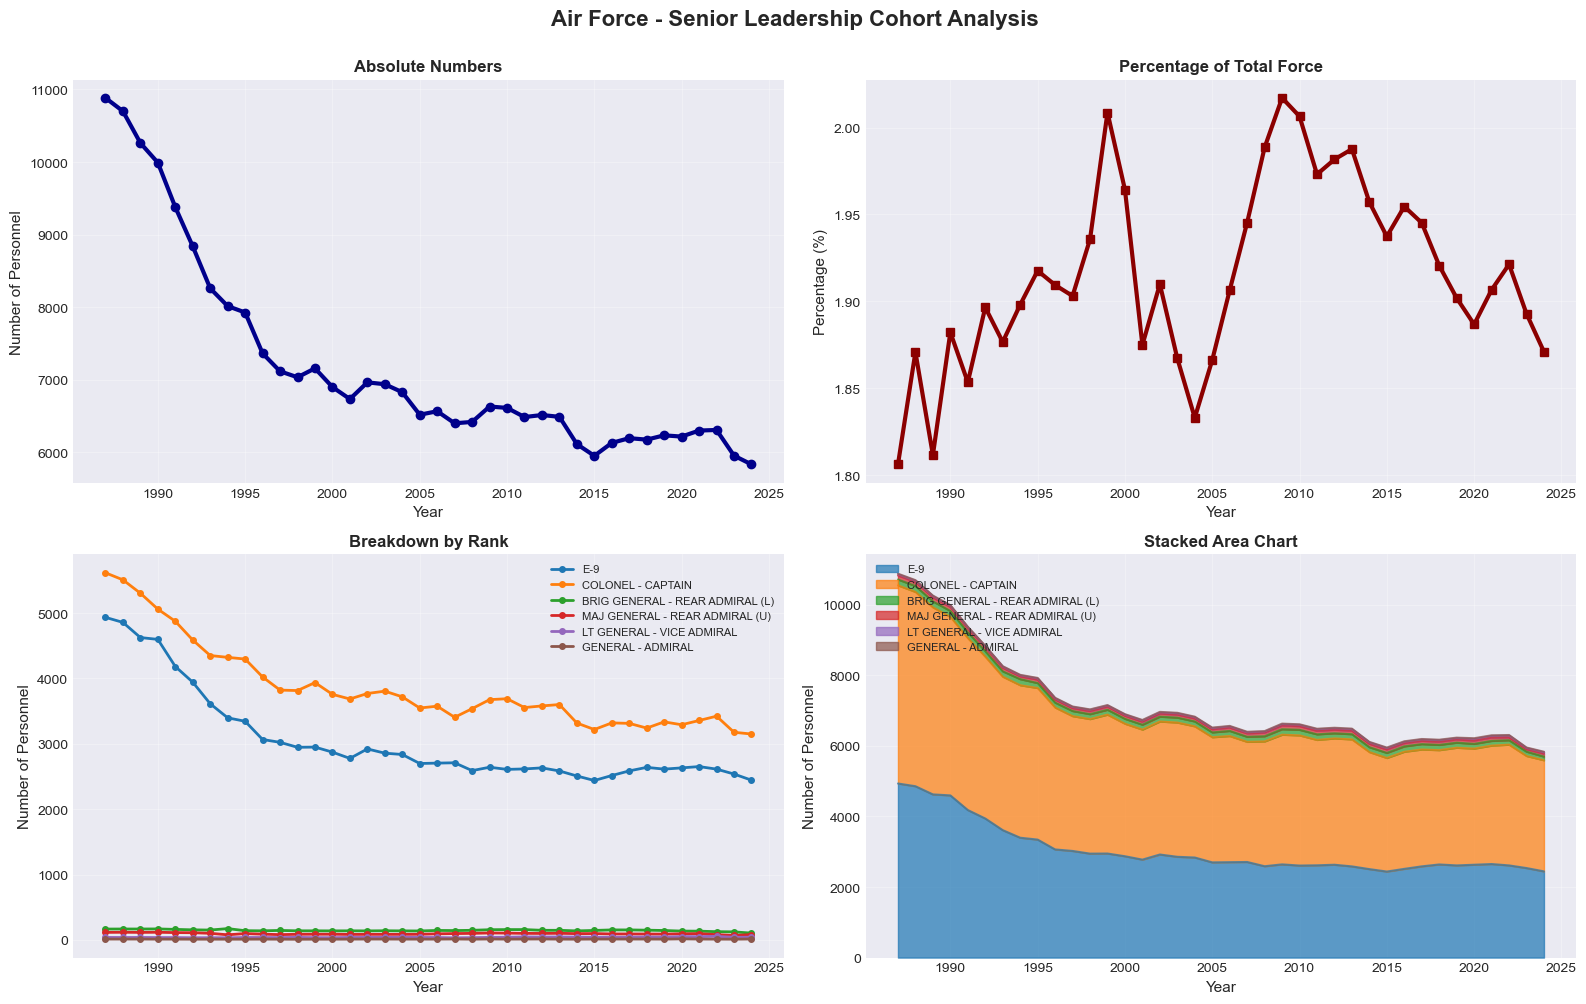


Generating senior cohort analysis for Space Force...


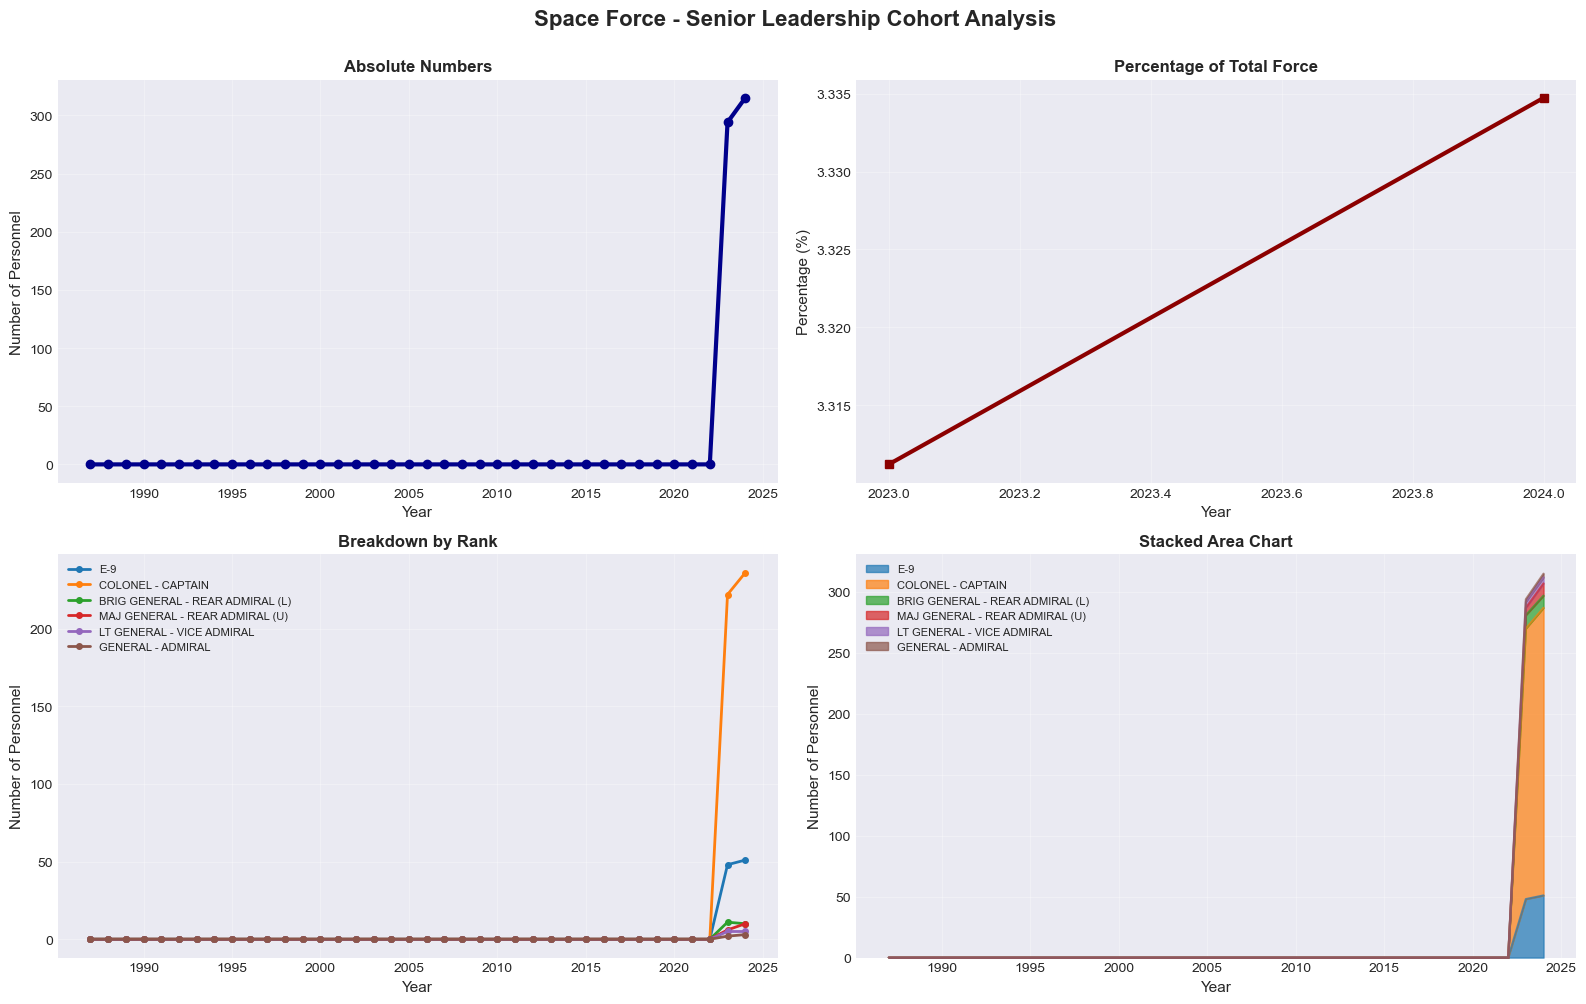

In [11]:
def plot_branch_senior_cohort(df, branch, figsize=(16, 10)):
    """Plot senior leadership cohort analysis for a specific branch"""
    
    df_branch = prepare_branch_data(df, branch)
    
    # Filter for senior cohort
    df_senior = df_branch[df_branch['Rank/Grade'].isin(SENIOR_COHORT)].copy()
    
    # Calculate totals
    senior_totals = df_senior.groupby('Year')['Personnel'].sum().reset_index()
    senior_totals.columns = ['Year', 'SeniorCohort']
    
    overall_totals = df_branch.groupby('Year')['Personnel'].sum().reset_index()
    overall_totals.columns = ['Year', 'OverallTotal']
    
    cohort_analysis = senior_totals.merge(overall_totals, on='Year')
    cohort_analysis['SeniorCohort_pct'] = (
        cohort_analysis['SeniorCohort'] / cohort_analysis['OverallTotal'] * 100
    )
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(f'{branch} - Senior Leadership Cohort Analysis', 
                 fontsize=16, fontweight='bold', y=1.00)
    
    # Plot 1: Absolute numbers
    axes[0, 0].plot(cohort_analysis['Year'], cohort_analysis['SeniorCohort'], 
                    linewidth=3, marker='o', markersize=6, color='darkblue')
    axes[0, 0].set_title('Absolute Numbers', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Number of Personnel', fontsize=11)
    axes[0, 0].set_xlabel('Year', fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Percentage
    axes[0, 1].plot(cohort_analysis['Year'], cohort_analysis['SeniorCohort_pct'], 
                    linewidth=3, marker='s', markersize=6, color='darkred')
    axes[0, 1].set_title('Percentage of Total Force', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Percentage (%)', fontsize=11)
    axes[0, 1].set_xlabel('Year', fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Breakdown by rank
    pivot_abs = df_senior.pivot(index='Year', columns='Rank/Grade', values='Personnel')
    rank_order_cohort = [r for r in SENIOR_COHORT if r in pivot_abs.columns]
    if rank_order_cohort:
        pivot_abs[rank_order_cohort].plot(ax=axes[1, 0], linewidth=2, 
                                          marker='o', markersize=4)
        axes[1, 0].set_title('Breakdown by Rank', fontsize=12, fontweight='bold')
        axes[1, 0].set_ylabel('Number of Personnel', fontsize=11)
        axes[1, 0].set_xlabel('Year', fontsize=11)
        axes[1, 0].legend(fontsize=8)
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 4: Stacked area
        pivot_abs[rank_order_cohort].plot.area(ax=axes[1, 1], alpha=0.7)
        axes[1, 1].set_title('Stacked Area Chart', fontsize=12, fontweight='bold')
        axes[1, 1].set_ylabel('Number of Personnel', fontsize=11)
        axes[1, 1].set_xlabel('Year', fontsize=11)
        axes[1, 1].legend(fontsize=8, loc='upper left')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, cohort_analysis

# Generate plots for each branch
branch_cohort_data = {}
for branch in BRANCHES:
    if branch_data[branch]['Personnel'].sum() > 0:  # Only plot if branch has data
        print(f"\nGenerating senior cohort analysis for {branch}...")
        fig, cohort_summary = plot_branch_senior_cohort(df_all, branch)
        branch_cohort_data[branch] = cohort_summary
        plt.show()


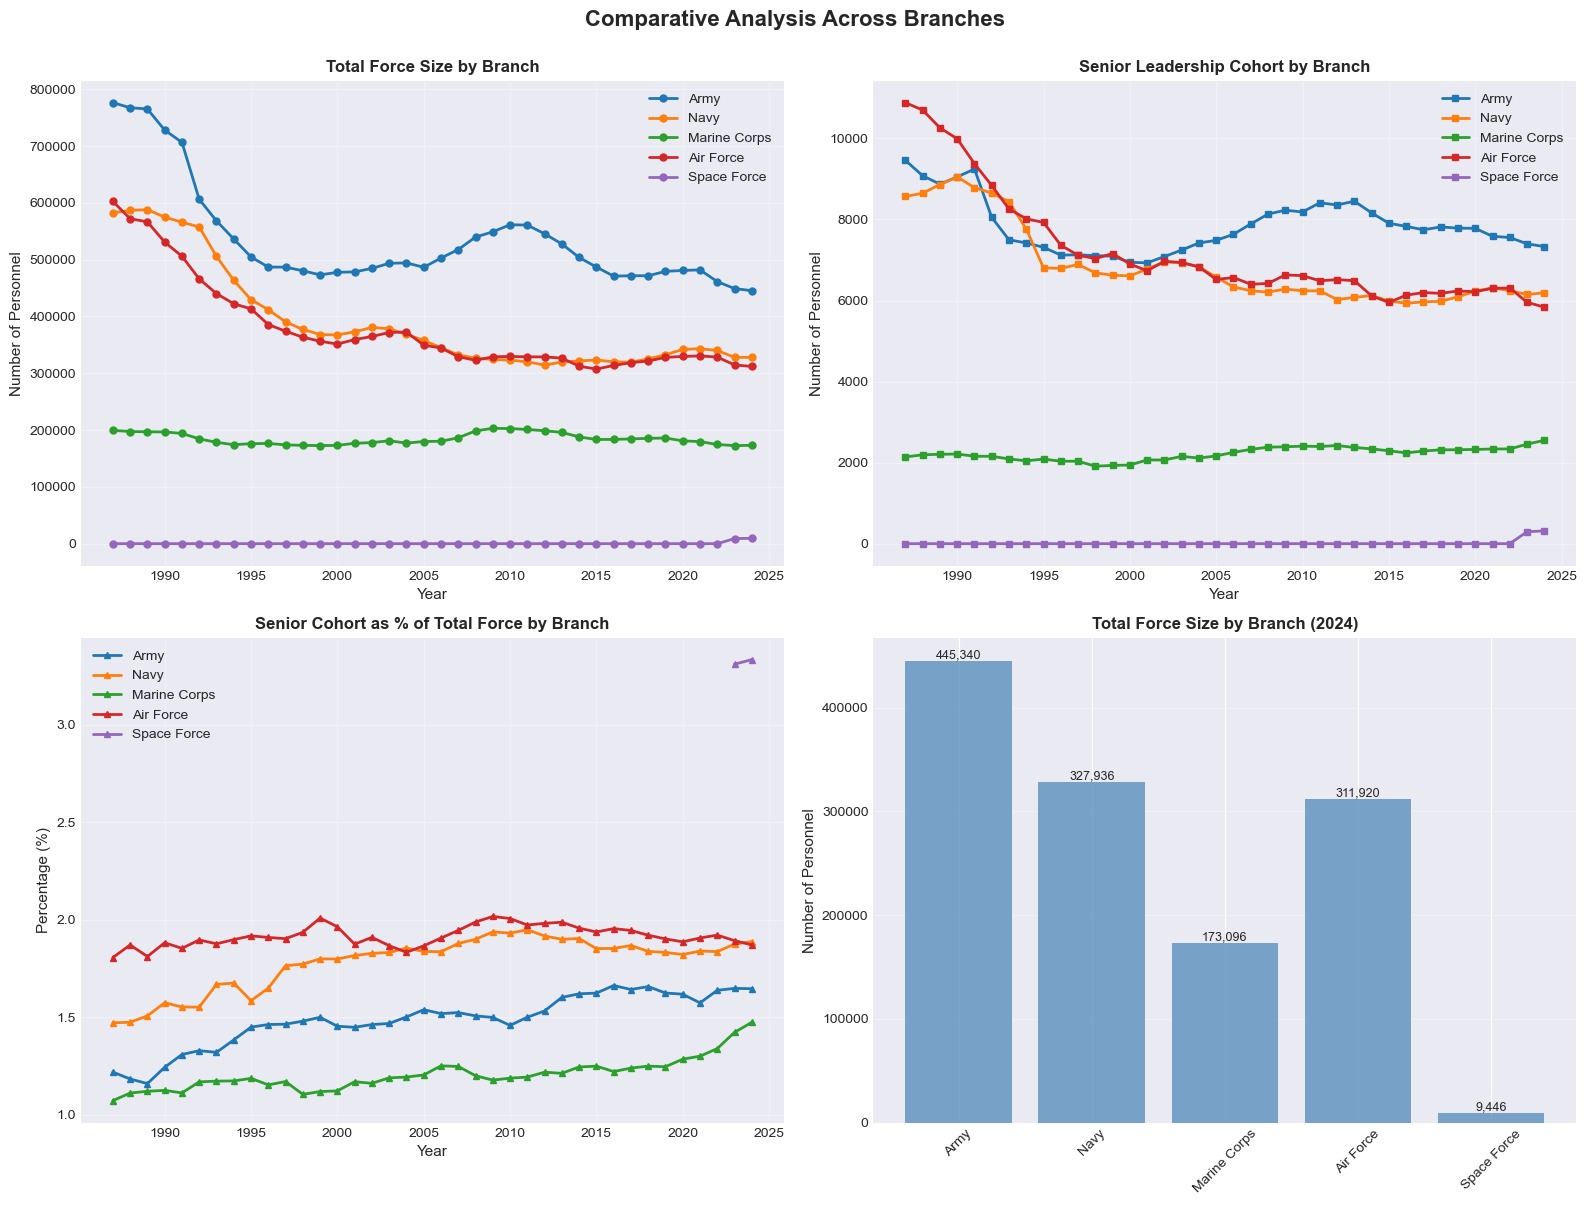


Comparative analysis across branches complete!


In [12]:
def plot_branch_comparison(df, figsize=(16, 12)):
    """Create comparative visualizations across all branches"""
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Comparative Analysis Across Branches', 
                 fontsize=16, fontweight='bold', y=1.00)
    
    # Plot 1: Total force size by branch
    for branch in BRANCHES:
        branch_totals = df.groupby('Year')[branch].sum()
        if branch_totals.sum() > 0:
            axes[0, 0].plot(branch_totals.index, branch_totals.values, 
                           linewidth=2, marker='o', markersize=5, label=branch)
    axes[0, 0].set_title('Total Force Size by Branch', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Number of Personnel', fontsize=11)
    axes[0, 0].set_xlabel('Year', fontsize=11)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Senior cohort size by branch
    for branch in BRANCHES:
        if branch in branch_cohort_data:
            cohort_data = branch_cohort_data[branch]
            axes[0, 1].plot(cohort_data['Year'], cohort_data['SeniorCohort'], 
                           linewidth=2, marker='s', markersize=5, label=branch)
    axes[0, 1].set_title('Senior Leadership Cohort by Branch', 
                        fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Number of Personnel', fontsize=11)
    axes[0, 1].set_xlabel('Year', fontsize=11)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Senior cohort percentage by branch
    for branch in BRANCHES:
        if branch in branch_cohort_data:
            cohort_data = branch_cohort_data[branch]
            axes[1, 0].plot(cohort_data['Year'], cohort_data['SeniorCohort_pct'], 
                           linewidth=2, marker='^', markersize=5, label=branch)
    axes[1, 0].set_title('Senior Cohort as % of Total Force by Branch', 
                        fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Percentage (%)', fontsize=11)
    axes[1, 0].set_xlabel('Year', fontsize=11)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Latest year comparison (2024)
    latest_year = df['Year'].max()
    df_latest = df[df['Year'] == latest_year]
    
    branch_totals_latest = []
    branch_names_plot = []
    for branch in BRANCHES:
        total = df_latest[branch].sum()
        if total > 0:
            branch_totals_latest.append(total)
            branch_names_plot.append(branch)
    
    axes[1, 1].bar(branch_names_plot, branch_totals_latest, color='steelblue', alpha=0.7)
    axes[1, 1].set_title(f'Total Force Size by Branch ({latest_year})', 
                        fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Number of Personnel', fontsize=11)
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(branch_totals_latest):
        axes[1, 1].text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    return fig

# Generate comparative plot
fig_comparison = plot_branch_comparison(df_all)
plt.show()

print("\nComparative analysis across branches complete!")



In [13]:
def generate_summary_statistics(df):
    """Generate comprehensive summary statistics"""
    
    summaries = {}
    
    # Overall DoD summary
    print("\n" + "="*60)
    print("OVERALL DoD SUMMARY STATISTICS")
    print("="*60)
    
    total_dod = df.groupby('Year')['Total DoD'].sum()
    print(f"\nTotal DoD Personnel Range:")
    print(f"  Minimum: {total_dod.min():,.0f} (Year {total_dod.idxmin()})")
    print(f"  Maximum: {total_dod.max():,.0f} (Year {total_dod.idxmax()})")
    print(f"  Latest (2024): {total_dod.iloc[-1]:,.0f}")
    print(f"  Change 1987-2024: {total_dod.iloc[-1] - total_dod.iloc[0]:,.0f} ({((total_dod.iloc[-1] / total_dod.iloc[0] - 1) * 100):.1f}%)")
    
    summaries['total_dod'] = total_dod
    
    # Branch summaries
    print("\n" + "="*60)
    print("BRANCH-SPECIFIC SUMMARIES")
    print("="*60)
    
    for branch in BRANCHES:
        branch_totals = df.groupby('Year')[branch].sum()
        if branch_totals.sum() > 0:
            print(f"\n{branch}:")
            print(f"  Minimum: {branch_totals.min():,.0f} (Year {branch_totals.idxmin()})")
            print(f"  Maximum: {branch_totals.max():,.0f} (Year {branch_totals.idxmax()})")
            print(f"  Latest: {branch_totals.iloc[-1]:,.0f}")
            print(f"  Change: {branch_totals.iloc[-1] - branch_totals.iloc[0]:,.0f} ({((branch_totals.iloc[-1] / branch_totals.iloc[0] - 1) * 100):.1f}%)")
            summaries[f'branch_{branch}'] = branch_totals
    
    # Senior cohort summary
    print("\n" + "="*60)
    print("SENIOR LEADERSHIP COHORT SUMMARY")
    print("="*60)
    
    df_senior = df[df['Rank/Grade'].isin(SENIOR_COHORT)]
    senior_totals = df_senior.groupby('Year')['Total DoD'].sum()
    overall_totals = df.groupby('Year')['Total DoD'].sum()
    senior_pct = (senior_totals / overall_totals * 100)
    
    print(f"\nSenior Cohort (E-9s, Colonels, Generals):")
    print(f"  Minimum: {senior_totals.min():,.0f} (Year {senior_totals.idxmin()})")
    print(f"  Maximum: {senior_totals.max():,.0f} (Year {senior_totals.idxmax()})")
    print(f"  Latest: {senior_totals.iloc[-1]:,.0f}")
    print(f"\nSenior Cohort as % of Total:")
    print(f"  Minimum: {senior_pct.min():.2f}% (Year {senior_pct.idxmin()})")
    print(f"  Maximum: {senior_pct.max():.2f}% (Year {senior_pct.idxmax()})")
    print(f"  Latest: {senior_pct.iloc[-1]:.2f}%")
    
    summaries['senior_cohort'] = senior_totals
    summaries['senior_cohort_pct'] = senior_pct
    
    return summaries

# Generate summary statistics
summary_stats = generate_summary_statistics(df_all)

# Create a summary DataFrame for easy export
summary_export = pd.DataFrame({
    'Year': df_all['Year'].unique()
})
summary_export = summary_export.sort_values('Year').reset_index(drop=True)

# Add DoD total
summary_export['Total_DoD'] = df_all.groupby('Year')['Total DoD'].sum().values

# Add branch totals
for branch in BRANCHES:
    summary_export[f'{branch.replace(" ", "_")}'] = df_all.groupby('Year')[branch].sum().values

# Add senior cohort data
df_senior = df_all[df_all['Rank/Grade'].isin(SENIOR_COHORT)]
summary_export['Senior_Cohort_Total'] = df_senior.groupby('Year')['Total DoD'].sum().values
summary_export['Senior_Cohort_Pct'] = (summary_export['Senior_Cohort_Total'] / summary_export['Total_DoD'] * 100)

print("\n" + "="*60)
print("Summary data prepared for export")
print("="*60)
print(summary_export.head(10))

# Save summary to CSV
summary_export.to_csv('military_rank_summary.csv', index=False)
print("\nSummary exported to: military_rank_summary.csv")


OVERALL DoD SUMMARY STATISTICS

Total DoD Personnel Range:
  Minimum: 1,267,738 (Year 2024)
  Maximum: 2,160,727 (Year 1987)
  Latest (2024): 1,267,738
  Change 1987-2024: -892,989 (-41.3%)

BRANCH-SPECIFIC SUMMARIES

Army:
  Minimum: 445,340 (Year 2024)
  Maximum: 776,374 (Year 1987)
  Latest: 445,340
  Change: -331,034 (-42.6%)

Navy:
  Minimum: 314,334 (Year 2012)
  Maximum: 588,051 (Year 1989)
  Latest: 327,936
  Change: -254,310 (-43.7%)

Marine Corps:
  Minimum: 172,577 (Year 2023)
  Maximum: 203,075 (Year 2009)
  Latest: 173,096
  Change: -26,429 (-13.2%)

Air Force:
  Minimum: 307,326 (Year 2015)
  Maximum: 602,582 (Year 1987)
  Latest: 311,920
  Change: -290,662 (-48.2%)

Space Force:
  Minimum: 0 (Year 1987)
  Maximum: 9,446 (Year 2024)
  Latest: 9,446
  Change: 9,446 (inf%)

SENIOR LEADERSHIP COHORT SUMMARY

Senior Cohort (E-9s, Colonels, Generals):
  Minimum: 22,135 (Year 2016)
  Maximum: 31,052 (Year 1987)
  Latest: 22,226

Senior Cohort as % of Total:
  Minimum: 1.43% (Y

C:\Users\zachh\AppData\Local\Temp\ipykernel_28588\2289492338.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"  Change: {branch_totals.iloc[-1] - branch_totals.iloc[0]:,.0f} ({((branch_totals.iloc[-1] / branch_totals.iloc[0] - 1) * 100):.1f}%)")


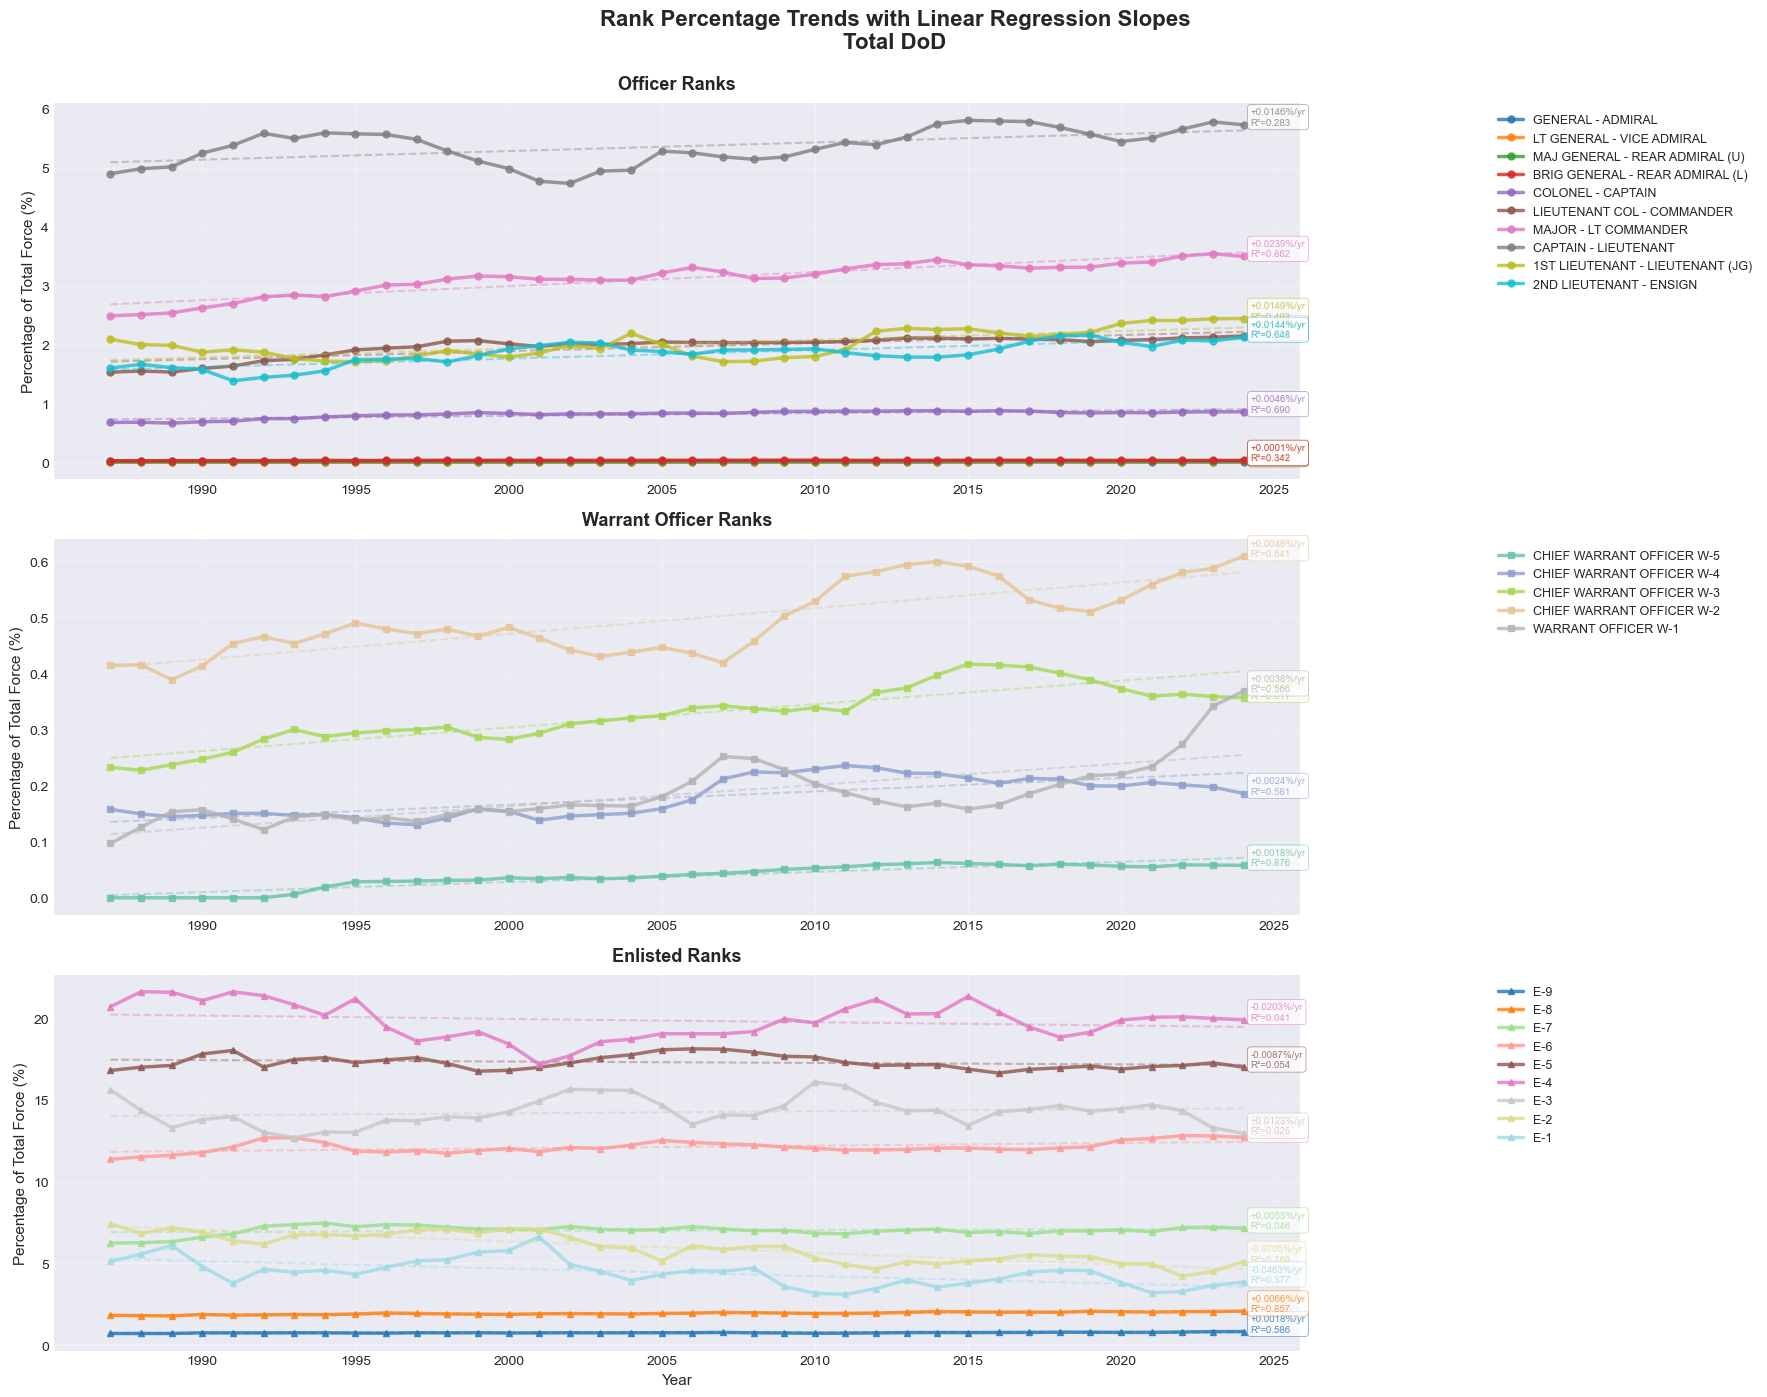

Linear regression analysis plot generated with slopes on graph


In [14]:
def perform_linear_regression(years, values):
    """
    Perform linear regression and return slope, intercept, r-value, p-value
    """
    # Remove any NaN values
    mask = ~np.isnan(values)
    years_clean = years[mask]
    values_clean = values[mask]
    
    if len(years_clean) < 2:
        return None, None, None, None, None
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(years_clean, values_clean)
    
    return slope, intercept, r_value, p_value, std_err


def plot_regression_with_slopes(df, column='Total DoD', figsize=(18, 14)):
    """
    Plot percentage trends with linear regression lines and slope annotations
    """
    # Calculate percentages
    df_pct = calculate_percentages(df, column)
    
    # Pivot data
    pivot_df = df_pct.pivot(index='Year', columns='Rank/Grade', values=f'{column}_pct')
    
    # Get all ranks in proper order
    all_ranks = OFFICER_RANKS + WARRANT_OFFICER_RANKS + ENLISTED_RANKS
    rank_cols = [r for r in all_ranks if r in pivot_df.columns]
    pivot_df = pivot_df[rank_cols]
    
    # Create distinct color palettes for each category
    officer_colors = plt.cm.tab10(np.linspace(0, 1, len(OFFICER_RANKS)))
    warrant_colors = plt.cm.Set2(np.linspace(0, 1, len(WARRANT_OFFICER_RANKS)))
    enlisted_colors = plt.cm.tab20(np.linspace(0, 1, len(ENLISTED_RANKS)))
    
    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    fig.suptitle(f'Rank Percentage Trends with Linear Regression Slopes\n{column}', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    years = pivot_df.index.values
    
    # Store regression results for table
    regression_results = []
    
    # Function to add slope annotation
    def add_slope_text(ax, rank, slope, r_squared, color):
        """Add slope annotation to plot"""
        y_pos = pivot_df[rank].iloc[-1]
        x_pos = years[-1]
        
        slope_text = f"{slope:+.4f}%/yr"
        r2_text = f"R²={r_squared:.3f}"
        
        ax.annotate(f'{slope_text}\n{r2_text}', 
                   xy=(x_pos, y_pos), 
                   xytext=(5, 0), 
                   textcoords='offset points',
                   fontsize=7,
                   color=color,
                   alpha=0.8,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                           edgecolor=color, alpha=0.7, linewidth=0.5))
    
    # Officers
    officer_cols = [r for r in OFFICER_RANKS if r in pivot_df.columns]
    if officer_cols:
        ax = axes[0]
        
        for i, rank in enumerate(officer_cols):
            values = pivot_df[rank].values
            color = officer_colors[i]
            line = ax.plot(years, values, linewidth=2.5, marker='o', markersize=5, 
                          label=rank, alpha=0.8, color=color)
            
            slope, intercept, r_value, p_value, std_err = perform_linear_regression(years, values)
            
            if slope is not None:
                regression_line = slope * years + intercept
                ax.plot(years, regression_line, linestyle='--', linewidth=1.5, 
                       alpha=0.4, color=color)
                add_slope_text(ax, rank, slope, r_value**2, color)
                
                regression_results.append({
                    'Rank': rank,
                    'Category': 'Officer',
                    'Slope (%/year)': slope,
                    'R²': r_value**2
                })
        
        ax.set_title('Officer Ranks', fontsize=13, fontweight='bold', pad=10)
        ax.set_ylabel('Percentage of Total Force (%)', fontsize=11)
        ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=9, 
                 framealpha=0.95, ncol=1)
        ax.grid(True, alpha=0.3)
    
    # Warrant Officers
    warrant_cols = [r for r in WARRANT_OFFICER_RANKS if r in pivot_df.columns]
    if warrant_cols:
        ax = axes[1]
        
        for i, rank in enumerate(warrant_cols):
            values = pivot_df[rank].values
            color = warrant_colors[i]
            line = ax.plot(years, values, linewidth=2.5, marker='s', markersize=5, 
                          label=rank, alpha=0.8, color=color)
            
            slope, intercept, r_value, p_value, std_err = perform_linear_regression(years, values)
            
            if slope is not None:
                regression_line = slope * years + intercept
                ax.plot(years, regression_line, linestyle='--', linewidth=1.5, 
                       alpha=0.4, color=color)
                add_slope_text(ax, rank, slope, r_value**2, color)
                
                regression_results.append({
                    'Rank': rank,
                    'Category': 'Warrant Officer',
                    'Slope (%/year)': slope,
                    'R²': r_value**2
                })
        
        ax.set_title('Warrant Officer Ranks', fontsize=13, fontweight='bold', pad=10)
        ax.set_ylabel('Percentage of Total Force (%)', fontsize=11)
        ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=9, 
                 framealpha=0.95, ncol=1)
        ax.grid(True, alpha=0.3)
    
    # Enlisted
    enlisted_cols = [r for r in ENLISTED_RANKS if r in pivot_df.columns]
    if enlisted_cols:
        ax = axes[2]
        
        for i, rank in enumerate(enlisted_cols):
            values = pivot_df[rank].values
            color = enlisted_colors[i]
            line = ax.plot(years, values, linewidth=2.5, marker='^', markersize=5, 
                          label=rank, alpha=0.8, color=color)
            
            slope, intercept, r_value, p_value, std_err = perform_linear_regression(years, values)
            
            if slope is not None:
                regression_line = slope * years + intercept
                ax.plot(years, regression_line, linestyle='--', linewidth=1.5, 
                       alpha=0.4, color=color)
                add_slope_text(ax, rank, slope, r_value**2, color)
                
                regression_results.append({
                    'Rank': rank,
                    'Category': 'Enlisted',
                    'Slope (%/year)': slope,
                    'R²': r_value**2
                })
        
        ax.set_title('Enlisted Ranks', fontsize=13, fontweight='bold', pad=10)
        ax.set_ylabel('Percentage of Total Force (%)', fontsize=11)
        ax.set_xlabel('Year', fontsize=11)
        ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=9, 
                 framealpha=0.95, ncol=1)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Create DataFrame from results
    results_df = pd.DataFrame(regression_results)
    
    return fig, results_df


# Generate the regression plot with slopes
fig_regression, regression_table = plot_regression_with_slopes(df_all, column='Total DoD')
plt.show()
print("Linear regression analysis plot generated with slopes on graph")

In [15]:
# Display the regression results table
print("\n" + "="*80)
print("REGRESSION ANALYSIS RESULTS - SLOPE BY RANK")
print("="*80)
print("\nSlope represents change in percentage points per year")
print("Positive = increasing share | Negative = decreasing share\n")

for category in ['Officer', 'Warrant Officer', 'Enlisted']:
    cat_data = regression_table[regression_table['Category'] == category]
    if len(cat_data) > 0:
        print(f"\n{category.upper()} RANKS:")
        print("-" * 80)
        print(cat_data.to_string(index=False))
        print()

# Show top gainers and losers
print("\n" + "="*80)
print("TOP 5 FASTEST GROWING RANKS (by percentage points):")
print(regression_table.nlargest(5, 'Slope (%/year)')[['Rank', 'Slope (%/year)', 'R²']].to_string(index=False))

print("\n" + "="*80)
print("TOP 5 FASTEST DECLINING RANKS (by percentage points):")
print(regression_table.nsmallest(5, 'Slope (%/year)')[['Rank', 'Slope (%/year)', 'R²']].to_string(index=False))
print("\n" + "="*80)


REGRESSION ANALYSIS RESULTS - SLOPE BY RANK

Slope represents change in percentage points per year
Positive = increasing share | Negative = decreasing share


OFFICER RANKS:
--------------------------------------------------------------------------------
                            Rank Category  Slope (%/year)       R²
               GENERAL - ADMIRAL  Officer        0.000038 0.882430
       LT GENERAL - VICE ADMIRAL  Officer        0.000182 0.920897
  MAJ GENERAL - REAR ADMIRAL (U)  Officer        0.000138 0.675423
 BRIG GENERAL - REAR ADMIRAL (L)  Officer        0.000138 0.342186
               COLONEL - CAPTAIN  Officer        0.004618 0.690153
      LIEUTENANT COL - COMMANDER  Officer        0.013671 0.700557
            MAJOR - LT COMMANDER  Officer        0.023858 0.862272
            CAPTAIN - LIEUTENANT  Officer        0.014605 0.282909
1ST LIEUTENANT - LIEUTENANT (JG)  Officer        0.014933 0.493273
         2ND LIEUTENANT - ENSIGN  Officer        0.014392 0.647578


WARRA